# Walmart : predict weekly sales

**Company's Description** 📇

Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville, Arkansas. The company was founded by Sam Walton in 1962.

**Project** 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

**Goals** 🎯

The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a **<ins>linear regression model</ins>** (baseline)
- Part 3 : avoid overfitting by training a **<ins>regularized regression model</ins>**

**Scope of this project** 🖼️

For this project, you'll work with a dataset that contains information about weekly sales achieved by different Walmart stores, and other variables such as the unemployment rate or the fuel price, that might be useful for predicting the amount of sales. The dataset has been taken from a Kaggle competition, but we made some changes compared to the original data. Please make sure that you're using **<ins>our</ins>** custom dataset (available on JULIE). 🤓

# Let's start the project

## 0/ import lib

In [274]:
# classical import 
import pandas as pd 
import numpy as np 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

# visualisation 
import seaborn as sns 
import plotly.express as px 
import plotly.graph_objects as go 
import missingno as msno
from IPython.display import display

# ML lib 
# 1 -> pre processing
import optuna 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

# 2 -> models 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet 

## 01/ import dataset

In [72]:
df = pd.read_csv('Walmart_Store_sales.csv')
df.head(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896
6,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658
7,20.0,03-02-2012,2203523.20,0.0,39.93,3.617,213.023622,6.961
8,14.0,10-12-2010,2600519.26,0.0,30.54,3.109,NaN,NaN
9,3.0,NaN,418925.47,0.0,60.12,3.555,224.132020,6.833


In [73]:
df.rename(columns={key:str.lower(key) for key in df.columns}, inplace=True)
df.sort_values(by='date', inplace=True)
df.replace('nan', np.nan, inplace=True)

# I/ EDA 

## 01/ rapid' coup d'oeil 

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 50 to 146
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         150 non-null    float64
 1   date          132 non-null    object 
 2   weekly_sales  136 non-null    float64
 3   holiday_flag  138 non-null    float64
 4   temperature   132 non-null    float64
 5   fuel_price    136 non-null    float64
 6   cpi           138 non-null    float64
 7   unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 10.5+ KB


In [75]:
df.describe(include='all')

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,07-01-2011,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


In [76]:
df['holiday_flag'].value_counts()

holiday_flag
0.0    127
1.0     11
Name: count, dtype: int64

In [77]:
df['store'].value_counts()

store
3.0     15
1.0     11
18.0    10
13.0     9
5.0      9
19.0     9
14.0     9
17.0     8
2.0      8
8.0      8
7.0      8
20.0     7
4.0      7
6.0      7
12.0     5
10.0     5
15.0     4
16.0     4
9.0      4
11.0     3
Name: count, dtype: int64

<Axes: >

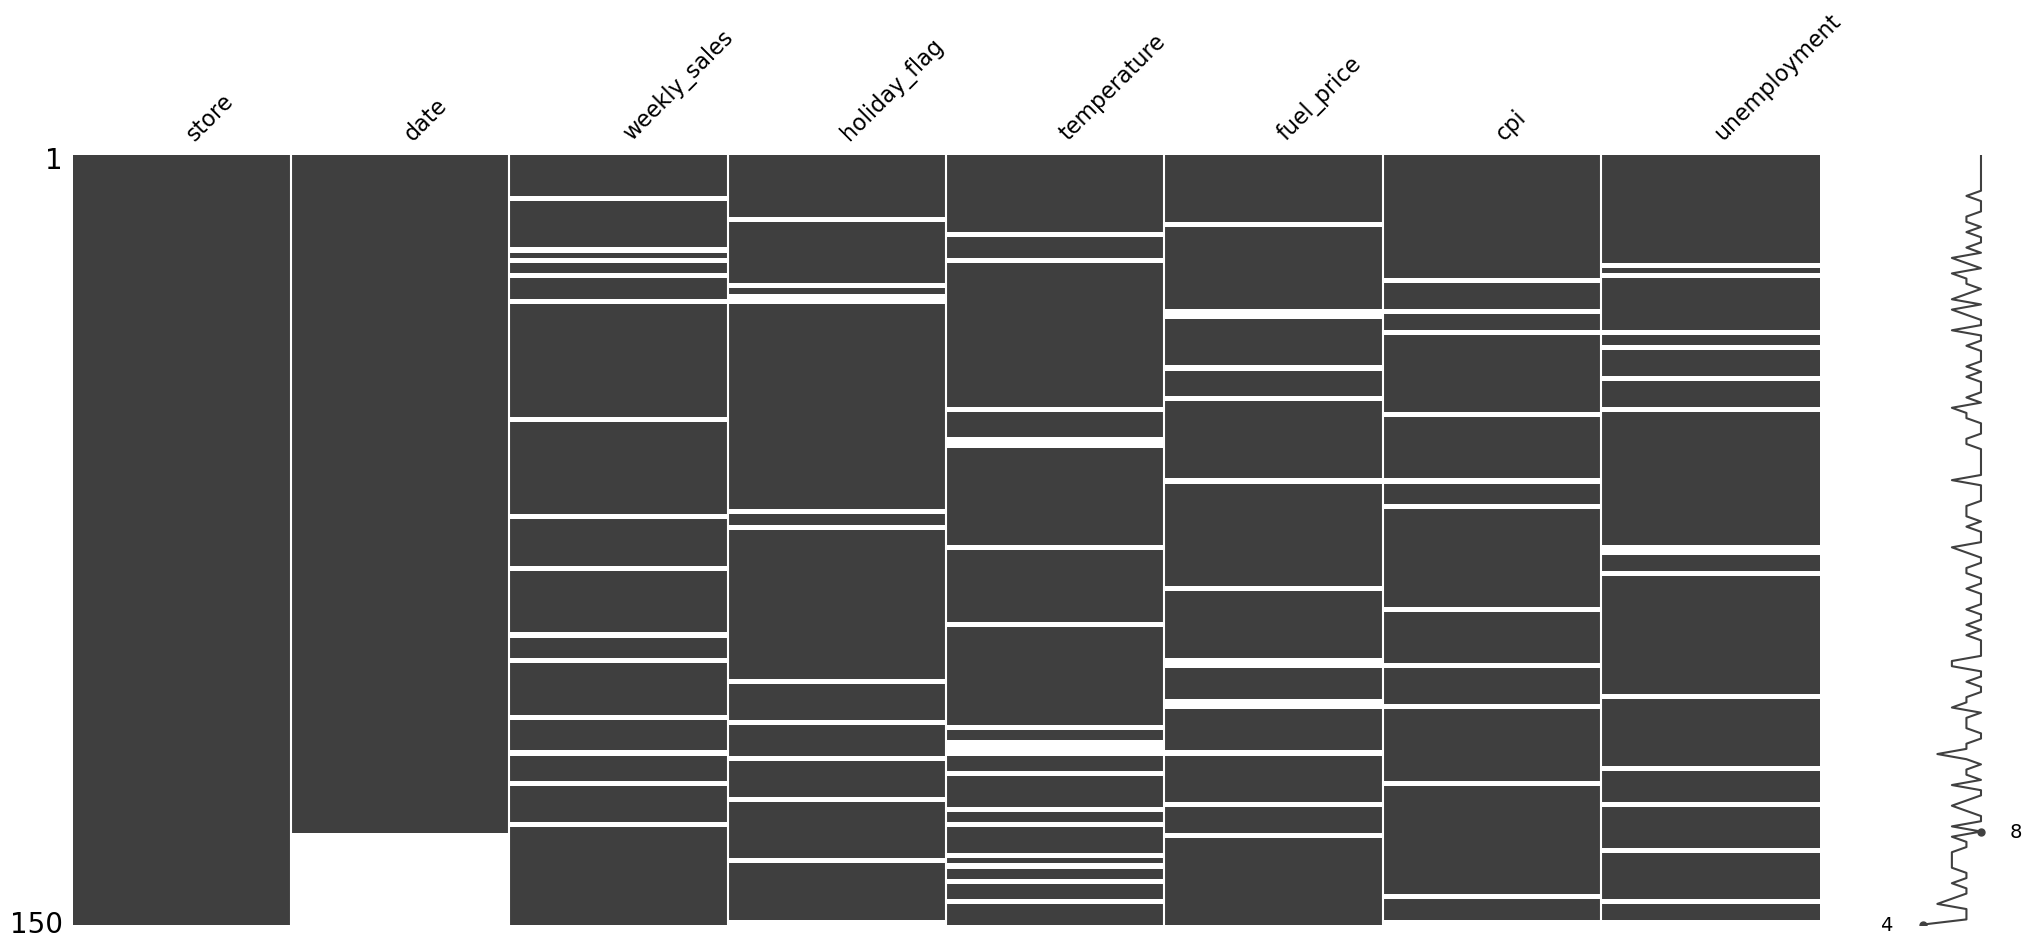

In [78]:
msno.matrix(df)

In [79]:
px.scatter_matrix(df, width=1000, height=1000)

In [80]:
for col in df.drop('weekly_sales', axis=1).columns:
    px.scatter(df, x=col, y='weekly_sales',
               width=600, height=300,).update_layout(margin=dict(l=10, r=10, t=10, b=10)).show()

In [81]:
px.imshow(df.corr(numeric_only=True))

# II/ preprocess

## 01/ drop na Weekly sales

In [82]:
df = df.dropna(axis=0, subset=['date', 'weekly_sales'])

In [83]:
df['date'].unique()

array(['01-06-2012', '01-10-2010', '02-03-2012', '02-04-2010',
       '02-07-2010', '03-02-2012', '03-06-2011', '04-05-2012',
       '04-06-2010', '05-02-2010', '05-08-2011', '06-01-2012',
       '06-05-2011', '06-07-2012', '06-08-2010', '07-01-2011',
       '07-09-2012', '07-10-2011', '08-07-2011', '09-07-2010',
       '10-02-2012', '10-06-2011', '10-09-2010', '10-12-2010',
       '11-05-2012', '11-06-2010', '11-11-2011', '12-02-2010',
       '12-03-2010', '12-08-2011', '12-10-2012', '12-11-2010',
       '13-01-2012', '13-05-2011', '14-05-2010', '14-09-2012',
       '15-04-2011', '15-07-2011', '15-10-2010', '16-03-2012',
       '16-04-2010', '16-12-2011', '17-02-2012', '17-09-2010',
       '17-12-2010', '18-02-2011', '18-06-2010', '18-11-2011',
       '19-02-2010', '19-08-2011', '19-10-2012', '19-11-2010',
       '20-01-2012', '20-04-2012', '20-05-2011', '20-08-2010',
       '22-04-2011', '22-06-2012', '22-07-2011', '23-09-2011',
       '24-02-2012', '24-06-2011', '24-09-2010', '25-03

## 02/ datetime creation

In [84]:
df_date = df.copy(deep=True)

In [85]:
df_date['date'] = pd.to_datetime(df_date['date'], dayfirst=True)
df_date['year'] = df_date['date'].dt.year
df_date['month'] = df_date['date'].dt.month
df_date['day'] = df_date['date'].dt.day
df_date['dayofweek'] = df_date['date'].dt.day_of_week
df_date["weekofyear"] = df_date["date"].dt.isocalendar().week.astype(float)
# df_date = df_date.drop(columns='date')

In [86]:
df_date.head(10)

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,year,month,day,dayofweek,weekofyear
50,13.0,2012-06-01,2035431.39,0.0,61.11,3.788,130.959226,5.965,2012,6,1,4,22.0
14,17.0,2010-10-01,829207.27,0.0,60.07,2.853,126.234600,6.885,2010,10,1,4,39.0
61,10.0,2012-03-02,1990371.02,0.0,57.62,3.882,130.645793,7.545,2012,3,2,4,9.0
20,7.0,2010-04-02,561145.14,0.0,38.26,2.725,189.704822,8.963,2010,4,2,4,13.0
47,19.0,2010-07-02,1549018.68,0.0,66.25,2.958,132.521867,8.099,2010,7,2,4,26.0
99,13.0,2010-07-02,2018314.71,0.0,78.82,2.814,126.139200,7.951,2010,7,2,4,26.0
7,20.0,2012-02-03,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,2,3,4,5.0
6,15.0,2011-06-03,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,4,22.0
24,19.0,2012-05-04,1405007.44,0.0,50.76,4.124,138.033200,8.150,2012,5,4,4,18.0
143,3.0,2010-06-04,396968.80,0.0,78.53,2.705,214.495838,7.343,2010,6,4,4,22.0


all report have the same day => Friday   
- This info have no importance, need to clean this one

In [87]:
df_date = df_date.drop(columns='dayofweek')

In [88]:
df_date.head(10)

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,year,month,day,weekofyear
50,13.0,2012-06-01,2035431.39,0.0,61.11,3.788,130.959226,5.965,2012,6,1,22.0
14,17.0,2010-10-01,829207.27,0.0,60.07,2.853,126.234600,6.885,2010,10,1,39.0
61,10.0,2012-03-02,1990371.02,0.0,57.62,3.882,130.645793,7.545,2012,3,2,9.0
20,7.0,2010-04-02,561145.14,0.0,38.26,2.725,189.704822,8.963,2010,4,2,13.0
47,19.0,2010-07-02,1549018.68,0.0,66.25,2.958,132.521867,8.099,2010,7,2,26.0
99,13.0,2010-07-02,2018314.71,0.0,78.82,2.814,126.139200,7.951,2010,7,2,26.0
7,20.0,2012-02-03,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,2,3,5.0
6,15.0,2011-06-03,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,22.0
24,19.0,2012-05-04,1405007.44,0.0,50.76,4.124,138.033200,8.150,2012,5,4,18.0
143,3.0,2010-06-04,396968.80,0.0,78.53,2.705,214.495838,7.343,2010,6,4,22.0


In [89]:
corr_matrix = df_date.corr().round(2)

import plotly.figure_factory as ff
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()

## 03/ gestion des NaN

### 001/ holidays nan

In [90]:
df_nan = df_date.copy(deep=True)

In [91]:
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 50 to 110
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         118 non-null    float64       
 1   date          118 non-null    datetime64[ns]
 2   weekly_sales  118 non-null    float64       
 3   holiday_flag  109 non-null    float64       
 4   temperature   107 non-null    float64       
 5   fuel_price    107 non-null    float64       
 6   cpi           109 non-null    float64       
 7   unemployment  107 non-null    float64       
 8   year          118 non-null    int32         
 9   month         118 non-null    int32         
 10  day           118 non-null    int32         
 11  weekofyear    118 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int32(3)
memory usage: 10.6 KB


In [92]:
import holidays
us_holidays = holidays.US()
df_nan['holiday_flag'] = df_nan['date'].apply(lambda x: 1 if x in us_holidays else 0)

In [93]:
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 50 to 110
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         118 non-null    float64       
 1   date          118 non-null    datetime64[ns]
 2   weekly_sales  118 non-null    float64       
 3   holiday_flag  118 non-null    int64         
 4   temperature   107 non-null    float64       
 5   fuel_price    107 non-null    float64       
 6   cpi           109 non-null    float64       
 7   unemployment  107 non-null    float64       
 8   year          118 non-null    int32         
 9   month         118 non-null    int32         
 10  day           118 non-null    int32         
 11  weekofyear    118 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int32(3), int64(1)
memory usage: 10.6 KB


### 002/ temp cpi unempl fuel price nan 

In [94]:
df_impute = df_nan.copy(deep=True)

In [95]:
df_impute

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,year,month,day,weekofyear
50,13.0,2012-06-01,2035431.39,0,61.11,3.788,130.959226,5.965,2012,6,1,22.0
14,17.0,2010-10-01,829207.27,0,60.07,2.853,126.234600,6.885,2010,10,1,39.0
61,10.0,2012-03-02,1990371.02,0,57.62,3.882,130.645793,7.545,2012,3,2,9.0
20,7.0,2010-04-02,561145.14,0,38.26,2.725,189.704822,8.963,2010,4,2,13.0
47,19.0,2010-07-02,1549018.68,0,66.25,2.958,132.521867,8.099,2010,7,2,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...
97,5.0,2010-04-30,298697.84,0,67.53,NaN,210.939388,NaN,2010,4,30,17.0
58,6.0,2010-07-30,1532308.78,0,NaN,2.640,212.894485,6.973,2010,7,30,30.0
105,19.0,2010-07-30,1366395.96,0,72.83,2.932,132.598387,8.099,2010,7,30,30.0
46,5.0,2010-07-30,268929.03,0,82.46,2.640,211.927001,6.496,2010,7,30,30.0


In [96]:
df_impute.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 50 to 110
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         118 non-null    float64       
 1   date          118 non-null    datetime64[ns]
 2   weekly_sales  118 non-null    float64       
 3   holiday_flag  118 non-null    int64         
 4   temperature   107 non-null    float64       
 5   fuel_price    107 non-null    float64       
 6   cpi           109 non-null    float64       
 7   unemployment  107 non-null    float64       
 8   year          118 non-null    int32         
 9   month         118 non-null    int32         
 10  day           118 non-null    int32         
 11  weekofyear    118 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int32(3), int64(1)
memory usage: 10.6 KB


In [97]:
col_simple_impute = ['cpi']
col_KNN_imput = ['temperature', 'fuel_price', 'unemployment']

for col in col_simple_impute: 
    df_impute[f'{col}'] = df_impute[f'{col}'].fillna(df_impute[f'{col}'].mean())

for col in col_KNN_imput:
    df_impute[f'{col}'] = df_impute[f'{col}'].interpolate(method='nearest')

In [98]:
df_impute.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 50 to 110
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         118 non-null    float64       
 1   date          118 non-null    datetime64[ns]
 2   weekly_sales  118 non-null    float64       
 3   holiday_flag  118 non-null    int64         
 4   temperature   118 non-null    float64       
 5   fuel_price    118 non-null    float64       
 6   cpi           118 non-null    float64       
 7   unemployment  118 non-null    float64       
 8   year          118 non-null    int32         
 9   month         118 non-null    int32         
 10  day           118 non-null    int32         
 11  weekofyear    118 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int32(3), int64(1)
memory usage: 10.6 KB


In [99]:
df_impute

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,year,month,day,weekofyear
50,13.0,2012-06-01,2035431.39,0,61.11,3.788,130.959226,5.965,2012,6,1,22.0
14,17.0,2010-10-01,829207.27,0,60.07,2.853,126.234600,6.885,2010,10,1,39.0
61,10.0,2012-03-02,1990371.02,0,57.62,3.882,130.645793,7.545,2012,3,2,9.0
20,7.0,2010-04-02,561145.14,0,38.26,2.725,189.704822,8.963,2010,4,2,13.0
47,19.0,2010-07-02,1549018.68,0,66.25,2.958,132.521867,8.099,2010,7,2,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...
97,5.0,2010-04-30,298697.84,0,67.53,2.854,210.939388,6.299,2010,4,30,17.0
58,6.0,2010-07-30,1532308.78,0,36.85,2.640,212.894485,6.973,2010,7,30,30.0
105,19.0,2010-07-30,1366395.96,0,72.83,2.932,132.598387,8.099,2010,7,30,30.0
46,5.0,2010-07-30,268929.03,0,82.46,2.640,211.927001,6.496,2010,7,30,30.0


### 003/ valeures aberantes

In [100]:
df_clean = df_impute.copy(deep=True)

In [101]:
df_clean['store'] = df_clean['store'].astype(str)
df_clean['holiday_flag'] = df_clean['holiday_flag'].astype(str)
df_clean = df_clean.drop(columns='date')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 50 to 110
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         118 non-null    object 
 1   weekly_sales  118 non-null    float64
 2   holiday_flag  118 non-null    object 
 3   temperature   118 non-null    float64
 4   fuel_price    118 non-null    float64
 5   cpi           118 non-null    float64
 6   unemployment  118 non-null    float64
 7   year          118 non-null    int32  
 8   month         118 non-null    int32  
 9   day           118 non-null    int32  
 10  weekofyear    118 non-null    float64
dtypes: float64(6), int32(3), object(2)
memory usage: 9.7+ KB


In [102]:
col_3sig = ['temperature', 'fuel_price', 'cpi', 'unemployment']
for col in col_3sig:
    mean = df_clean[f'{col}'].mean()
    std = df_clean[f'{col}'].std()
    df_clean = df_clean[(df_clean[f'{col}'] > mean - 3*std) & (df_clean[f'{col}'] < mean + 3*std)]

In [103]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113 entries, 50 to 110
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         113 non-null    object 
 1   weekly_sales  113 non-null    float64
 2   holiday_flag  113 non-null    object 
 3   temperature   113 non-null    float64
 4   fuel_price    113 non-null    float64
 5   cpi           113 non-null    float64
 6   unemployment  113 non-null    float64
 7   year          113 non-null    int32  
 8   month         113 non-null    int32  
 9   day           113 non-null    int32  
 10  weekofyear    113 non-null    float64
dtypes: float64(6), int32(3), object(2)
memory usage: 9.3+ KB


In [105]:
corr_matrix = df_clean.corr().round(2)

import plotly.figure_factory as ff
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()

## 04/ preprocess

In [240]:
df_prepro = df_clean.copy(deep=True)

In [241]:
df_prepro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113 entries, 50 to 110
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         113 non-null    object 
 1   weekly_sales  113 non-null    float64
 2   holiday_flag  113 non-null    object 
 3   temperature   113 non-null    float64
 4   fuel_price    113 non-null    float64
 5   cpi           113 non-null    float64
 6   unemployment  113 non-null    float64
 7   year          113 non-null    int32  
 8   month         113 non-null    int32  
 9   day           113 non-null    int32  
 10  weekofyear    113 non-null    float64
dtypes: float64(6), int32(3), object(2)
memory usage: 9.3+ KB


In [242]:
target = 'weekly_sales'

y = df_prepro[[target]]
X = df_prepro.drop(target, axis=1)

In [243]:
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [244]:
numeric_features = ['temperature', 'fuel_price', 'cpi', 'unemployment']
categorical_features = [feature for feature in X.columns if feature not in numeric_features]

In [245]:
for col in categorical_features:
    train_unique = set(x_train[col].unique())
    test_unique = set(x_test[col].unique())
    diff = test_unique - train_unique
    if diff:
        print(f"⚠️ Colonne {col} contient des catégories inconnues : {diff}")

⚠️ Colonne day contient des catégories inconnues : {np.int32(5)}
⚠️ Colonne weekofyear contient des catégories inconnues : {np.float64(3.0), np.float64(36.0), np.float64(29.0), np.float64(15.0)}


In [246]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first',
                                        categories=[sorted(X[col].unique().tolist()) for col in categorical_features])

In [ ]:
# other method =>

# numeric_transformer = StandardScaler()
# categorical_transformer = OneHotEncoder(drop='first',
#                                         handle_unknown='ignore')

In [248]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features), 
    ])

In [249]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(x_train.head())
x_train = preprocessor.fit_transform(x_train)
print('...Done.')
print(x_train[0:5]) # MUST use this syntax because x_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(x_test.head()) 
x_test = preprocessor.transform(x_test) # Don't fit again !! 
print('...Done.')
print(x_test[0:5,:]) # MUST use this syntax because x_test is a numpy array and not a pandas DataFrame anymore

Performing preprocessings on train set...
    store holiday_flag  temperature  fuel_price         cpi  unemployment  \
39    5.0            1        60.71       3.297  218.569962         6.300   
10    8.0            0        82.92       3.554  219.070197         6.425   
105  19.0            0        72.83       2.932  132.598387         8.099   
15    6.0            0        68.91       2.780  211.894272         7.092   
90    9.0            0        78.51       2.642  214.656430         6.442   

     year  month  day  weekofyear  
39   2011     11   11        45.0  
10   2011      8   19        33.0  
105  2010      7   30        30.0  
15   2010      4   30        17.0  
90   2010      7    9        27.0  
...Done.
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 43 stored elements and shape (5, 109)>
  Coords	Values
  (0, 0)	0.108142493639545
  (0, 1)	0.07067920868326778
  (0, 2)	1.0542120417060707
  (0, 3)	-1.1223873575848515
  (0, 17)	1.0
  (0, 22)	1.0
  (0, 23)	1.

# III/ Baseline model

In [290]:
def score_model(model):
    print(model.score(x_train, y_train))
    print(model.score(x_test, y_test))

In [291]:
baseline_model = LinearRegression()
baseline_model.fit(x_train, y_train)

score_model(baseline_model)

0.9990614146466275
0.6053480292887657


In [313]:
import plotly.graph_objects as go

fig = px.line(x=y_test.values.flatten(), y=y_test.values.flatten())
fig.add_trace(go.Scatter(x=y_test.values.flatten(), y=baseline_model.predict(x_test).flatten(), mode='markers'))
fig.show()

# IV/ Ridge VS Lasso

## 01/ Ridge

In [293]:
print('Ridge 1 :')
ridge_1 = Ridge(alpha=1)
ridge_1.fit(x_train, y_train)
score_model(ridge_1)

print('\n')
print('Ridge 2 :')
ridge_2 = Ridge(alpha=1e6) # 1e6 = 1_000_000 = 1000000
ridge_2.fit(x_train, y_train)
score_model(ridge_2)

print('\n')
print('Ridge 3 :')
ridge_3 = Ridge(alpha=1e8)
ridge_3.fit(x_train, y_train)
score_model(ridge_3)

Ridge 1 :
0.9634227652442642
0.6938023351926523


Ridge 2 :
5.746954423235806e-05
-0.08305868836837815


Ridge 3 :
5.74738109881956e-07
-0.08309781436548791


In [294]:
ridge_feature_importance = pd.DataFrame(
    {
    'feature': preprocessor.get_feature_names_out(),
    'coef_1e0': ridge_1.coef_[0],
    'coef_1e6': ridge_2.coef_[0],
    'coef_1e8': ridge_3.coef_[0]
    }
)

ridge_feature_importance

,feature,coef_1e0,coef_1e6,coef_1e8
0,num__temperature,15167.42222,-12.534444,-0.125348
1,num__fuel_price,15167.42222,-12.534444,-0.125348
2,num__cpi,15167.42222,-12.534444,-0.125348
3,num__unemployment,15167.42222,-12.534444,-0.125348
4,cat__store_10.0,15167.42222,-12.534444,-0.125348
...,...,...,...,...
104,cat__weekofyear_46.0,15167.42222,-12.534444,-0.125348
105,cat__weekofyear_47.0,15167.42222,-12.534444,-0.125348
106,cat__weekofyear_49.0,15167.42222,-12.534444,-0.125348
107,cat__weekofyear_50.0,15167.42222,-12.534444,-0.125348


In [295]:
px.line(ridge_feature_importance, 
        x='feature', 
        y=['coef_1e0', 'coef_1e6', 'coef_1e8'])

## 02/ Lasso 

In [296]:
print('lasso 1 :')
lasso1 = Lasso(alpha=1)
lasso1.fit(x_train, y_train)
score_model(lasso1)

print('\n')
print('lasso 2 :')
lasso2 = Lasso(alpha=1e3)
lasso2.fit(x_train, y_train)
score_model(lasso2)

print('\n')
print('lasso 3 :')
lasso3 = Lasso(alpha=1e4)
lasso3.fit(x_train, y_train)
score_model(lasso3)

print('\n')
print('lasso 4 :')
lasso4 = Lasso(alpha=1e5)
lasso4.fit(x_train, y_train)
score_model(lasso4)

lasso 1 :
0.9990198173391756
0.7771840891533163


lasso 2 :
0.9923793702155411
0.9616229947482027


lasso 3 :
0.889095058409265
0.7027430134409716


lasso 4 :
0.11069062561106846
0.021899470979823255


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.183e+10, tolerance: 4.086e+09



In [297]:
lasso_feature_importance = pd.DataFrame(
    {
    'feature': preprocessor.get_feature_names_out(),
    'coef_1e0': lasso1.coef_,
    'coef_1e3': lasso2.coef_,
    'coef_1e4': lasso3.coef_,
    'coef_1e5': lasso4.coef_
    }
)

lasso_feature_importance

,feature,coef_1e0,coef_1e3,coef_1e4,coef_1e5
0,num__temperature,18069.600630,24705.462239,-0.000000,-26420.182442
1,num__fuel_price,186711.689523,-14176.548970,-4543.685230,-0.000000
2,num__cpi,271309.884958,27192.967725,-26298.061515,-130066.816708
3,num__unemployment,-28611.174737,-23406.588131,22914.980838,2598.028567
4,cat__store_10.0,910921.286549,334020.218957,199079.485101,0.000000
...,...,...,...,...,...
104,cat__weekofyear_46.0,157779.431369,0.000000,-0.000000,-0.000000
105,cat__weekofyear_47.0,-34367.755615,0.000000,0.000000,0.000000
106,cat__weekofyear_49.0,70489.639768,0.000000,0.000000,0.000000
107,cat__weekofyear_50.0,-1540.881362,110621.401159,0.000000,0.000000


In [298]:
px.line(lasso_feature_importance, 
        x='feature', 
        y=['coef_1e0', 'coef_1e3', 'coef_1e4', 'coef_1e5'])

# V/ Bonus question

In [299]:
params_ridge = {
    'alpha': np.logspace(-1, 3, 100)
}

ridge = Ridge(max_iter=10_000)

ridge_search = GridSearchCV(ridge, params_ridge, verbose=3)

ridge_search.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .........................alpha=0.1;, score=0.788 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.927 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.914 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.703 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.704 total time=   0.0s
[CV 1/5] END .........alpha=0.10974987654930562;, score=0.793 total time=   0.0s
[CV 2/5] END .........alpha=0.10974987654930562;, score=0.927 total time=   0.0s
[CV 3/5] END .........alpha=0.10974987654930562;, score=0.913 total time=   0.0s
[CV 4/5] END .........alpha=0.10974987654930562;, score=0.706 total time=   0.0s
[CV 5/5] END .........alpha=0.10974987654930562;, score=0.701 total time=   0.0s
[CV 1/5] END .........alpha=0.12045035402587821;, score=0.797 total time=   0.0s
[CV 2/5] END .........alpha=0.1204503540258782

,estimator,Ridge(max_iter=10000)
,param_grid,{'alpha': array([1.0000...00000000e+03])}
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(0.1321941148466029)


In [300]:
params_lasso = {
    'alpha': np.logspace(0, 5, 100)
}

lasso = Lasso(max_iter=10_000)

lasso_search = GridSearchCV(lasso, params_lasso, verbose=3)

lasso_search.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .........................alpha=1.0;, score=0.615 total time=   0.0s
[CV 2/5] END .........................alpha=1.0;, score=0.709 total time=   0.0s
[CV 3/5] END .........................alpha=1.0;, score=0.573 total time=   0.0s
[CV 4/5] END .........................alpha=1.0;, score=0.616 total time=   0.0s
[CV 5/5] END .........................alpha=1.0;, score=0.168 total time=   0.0s
[CV 1/5] END ..........alpha=1.1233240329780274;, score=0.622 total time=   0.0s
[CV 2/5] END ..........alpha=1.1233240329780274;, score=0.723 total time=   0.0s
[CV 3/5] END ..........alpha=1.1233240329780274;, score=0.572 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.654e+09, tolerance: 3.139e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.716e+09, tolerance: 3.139e+09



[CV 4/5] END ..........alpha=1.1233240329780274;, score=0.625 total time=   0.0s
[CV 5/5] END ..........alpha=1.1233240329780274;, score=0.174 total time=   0.0s
[CV 1/5] END ..........alpha=1.2618568830660204;, score=0.628 total time=   0.0s
[CV 2/5] END ..........alpha=1.2618568830660204;, score=0.737 total time=   0.0s
[CV 3/5] END ..........alpha=1.2618568830660204;, score=0.568 total time=   0.0s
[CV 4/5] END ..........alpha=1.2618568830660204;, score=0.636 total time=   0.0s
[CV 5/5] END ..........alpha=1.2618568830660204;, score=0.180 total time=   0.0s
[CV 1/5] END ..........alpha=1.4174741629268053;, score=0.634 total time=   0.0s
[CV 2/5] END ..........alpha=1.4174741629268053;, score=0.750 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.684e+09, tolerance: 3.139e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.704e+09, tolerance: 3.139e+09



[CV 3/5] END ..........alpha=1.4174741629268053;, score=0.566 total time=   0.0s
[CV 4/5] END ..........alpha=1.4174741629268053;, score=0.645 total time=   0.0s
[CV 5/5] END ..........alpha=1.4174741629268053;, score=0.169 total time=   0.0s
[CV 1/5] END ..........alpha=1.5922827933410924;, score=0.644 total time=   0.0s
[CV 2/5] END ..........alpha=1.5922827933410924;, score=0.780 total time=   0.0s
[CV 3/5] END ..........alpha=1.5922827933410924;, score=0.564 total time=   0.0s
[CV 4/5] END ..........alpha=1.5922827933410924;, score=0.658 total time=   0.0s
[CV 5/5] END ..........alpha=1.5922827933410924;, score=0.133 total time=   0.0s
[CV 1/5] END ...........alpha=1.788649529057435;, score=0.654 total time=   0.0s
[CV 2/5] END ...........alpha=1.788649529057435;, score=0.802 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.697e+09, tolerance: 3.139e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.676e+09, tolerance: 3.139e+09



[CV 3/5] END ...........alpha=1.788649529057435;, score=0.566 total time=   0.0s
[CV 4/5] END ...........alpha=1.788649529057435;, score=0.680 total time=   0.0s
[CV 5/5] END ...........alpha=1.788649529057435;, score=0.123 total time=   0.0s
[CV 1/5] END ..........alpha=2.0092330025650473;, score=0.665 total time=   0.0s
[CV 2/5] END ..........alpha=2.0092330025650473;, score=0.806 total time=   0.0s
[CV 3/5] END ..........alpha=2.0092330025650473;, score=0.567 total time=   0.0s
[CV 4/5] END ..........alpha=2.0092330025650473;, score=0.688 total time=   0.0s
[CV 5/5] END ..........alpha=2.0092330025650473;, score=0.097 total time=   0.0s
[CV 1/5] END ............alpha=2.25701971963392;, score=0.655 total time=   0.0s
[CV 2/5] END ............alpha=2.25701971963392;, score=0.800 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.415e+09, tolerance: 3.139e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.351e+09, tolerance: 3.328e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.360e+09, tolerance: 3.139e+09



[CV 3/5] END ............alpha=2.25701971963392;, score=0.567 total time=   0.0s
[CV 4/5] END ............alpha=2.25701971963392;, score=0.720 total time=   0.0s
[CV 5/5] END ............alpha=2.25701971963392;, score=0.088 total time=   0.0s
[CV 1/5] END ...........alpha=2.535364493970112;, score=0.663 total time=   0.0s
[CV 2/5] END ...........alpha=2.535364493970112;, score=0.806 total time=   0.0s
[CV 3/5] END ...........alpha=2.535364493970112;, score=0.575 total time=   0.0s
[CV 4/5] END ...........alpha=2.535364493970112;, score=0.787 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.722e+09, tolerance: 3.328e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.936e+09, tolerance: 3.139e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.131e+09, tolerance: 3.328e+09

c:\Users\alber\anaconda3\

[CV 5/5] END ...........alpha=2.535364493970112;, score=0.078 total time=   0.0s
[CV 1/5] END ..........alpha=2.8480358684358014;, score=0.626 total time=   0.0s
[CV 2/5] END ..........alpha=2.8480358684358014;, score=0.814 total time=   0.0s
[CV 3/5] END ..........alpha=2.8480358684358014;, score=0.578 total time=   0.0s
[CV 4/5] END ..........alpha=2.8480358684358014;, score=0.825 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.612e+09, tolerance: 3.328e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e+09, tolerance: 3.139e+09



[CV 5/5] END ..........alpha=2.8480358684358014;, score=0.062 total time=   0.0s
[CV 1/5] END ..........alpha=3.1992671377973836;, score=0.635 total time=   0.0s
[CV 2/5] END ..........alpha=3.1992671377973836;, score=0.826 total time=   0.0s
[CV 3/5] END ..........alpha=3.1992671377973836;, score=0.581 total time=   0.0s
[CV 4/5] END ..........alpha=3.1992671377973836;, score=0.849 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.069e+09, tolerance: 3.328e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.760e+09, tolerance: 3.139e+09



[CV 5/5] END ..........alpha=3.1992671377973836;, score=0.049 total time=   0.0s
[CV 1/5] END ..........alpha=3.5938136638046276;, score=0.654 total time=   0.0s
[CV 2/5] END ..........alpha=3.5938136638046276;, score=0.846 total time=   0.0s
[CV 3/5] END ..........alpha=3.5938136638046276;, score=0.584 total time=   0.0s
[CV 4/5] END ..........alpha=3.5938136638046276;, score=0.858 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.162e+09, tolerance: 3.328e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.408e+09, tolerance: 3.139e+09



[CV 5/5] END ..........alpha=3.5938136638046276;, score=0.024 total time=   0.0s
[CV 1/5] END ..........alpha=4.0370172585965545;, score=0.672 total time=   0.0s
[CV 2/5] END ..........alpha=4.0370172585965545;, score=0.840 total time=   0.0s
[CV 3/5] END ..........alpha=4.0370172585965545;, score=0.601 total time=   0.0s
[CV 4/5] END ..........alpha=4.0370172585965545;, score=0.862 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.300e+09, tolerance: 3.328e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.137e+09, tolerance: 3.139e+09



[CV 5/5] END ..........alpha=4.0370172585965545;, score=0.021 total time=   0.0s
[CV 1/5] END ...........alpha=4.534878508128582;, score=0.683 total time=   0.0s
[CV 2/5] END ...........alpha=4.534878508128582;, score=0.845 total time=   0.0s
[CV 3/5] END ...........alpha=4.534878508128582;, score=0.635 total time=   0.0s
[CV 4/5] END ...........alpha=4.534878508128582;, score=0.872 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.515e+09, tolerance: 3.328e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.700e+09, tolerance: 3.139e+09



[CV 5/5] END ...........alpha=4.534878508128582;, score=0.029 total time=   0.0s
[CV 1/5] END ...........alpha=5.094138014816379;, score=0.700 total time=   0.0s
[CV 2/5] END ...........alpha=5.094138014816379;, score=0.853 total time=   0.0s
[CV 3/5] END ...........alpha=5.094138014816379;, score=0.659 total time=   0.0s
[CV 4/5] END ...........alpha=5.094138014816379;, score=0.876 total time=   0.0s
[CV 5/5] END ...........alpha=5.094138014816379;, score=0.034 total time=   0.0s
[CV 1/5] END ...........alpha=5.722367659350217;, score=0.717 total time=   0.0s
[CV 2/5] END ...........alpha=5.722367659350217;, score=0.864 total time=   0.0s
[CV 3/5] END ...........alpha=5.722367659350217;, score=0.681 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.897e+09, tolerance: 3.328e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.346e+09, tolerance: 3.328e+09



[CV 4/5] END ...........alpha=5.722367659350217;, score=0.881 total time=   0.0s
[CV 5/5] END ...........alpha=5.722367659350217;, score=0.032 total time=   0.0s
[CV 1/5] END ............alpha=6.42807311728432;, score=0.723 total time=   0.0s
[CV 2/5] END ............alpha=6.42807311728432;, score=0.853 total time=   0.0s
[CV 3/5] END ............alpha=6.42807311728432;, score=0.688 total time=   0.0s
[CV 4/5] END ............alpha=6.42807311728432;, score=0.886 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.934e+09, tolerance: 3.328e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.414e+09, tolerance: 3.177e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.493e+09, tolerance: 3.328e+09



[CV 5/5] END ............alpha=6.42807311728432;, score=0.035 total time=   0.0s
[CV 1/5] END ...........alpha=7.220809018385464;, score=0.731 total time=   0.0s
[CV 2/5] END ...........alpha=7.220809018385464;, score=0.857 total time=   0.0s
[CV 3/5] END ...........alpha=7.220809018385464;, score=0.698 total time=   0.0s
[CV 4/5] END ...........alpha=7.220809018385464;, score=0.892 total time=   0.0s
[CV 5/5] END ...........alpha=7.220809018385464;, score=0.036 total time=   0.0s
[CV 1/5] END ............alpha=8.11130830789687;, score=0.743 total time=   0.0s
[CV 2/5] END ............alpha=8.11130830789687;, score=0.865 total time=   0.0s
[CV 3/5] END ............alpha=8.11130830789687;, score=0.713 total time=   0.0s
[CV 4/5] END ............alpha=8.11130830789687;, score=0.897 total time=   0.0s
[CV 5/5] END ............alpha=8.11130830789687;, score=0.047 total time=   0.0s
[CV 1/5] END ...........alpha=9.111627561154892;, score=0.752 total time=   0.0s
[CV 2/5] END ...........alph

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.351e+09, tolerance: 3.328e+09



[CV 3/5] END ...........alpha=9.111627561154892;, score=0.731 total time=   0.0s
[CV 4/5] END ...........alpha=9.111627561154892;, score=0.902 total time=   0.0s
[CV 5/5] END ...........alpha=9.111627561154892;, score=0.122 total time=   0.0s
[CV 1/5] END ..........alpha=10.235310218990262;, score=0.771 total time=   0.0s
[CV 2/5] END ..........alpha=10.235310218990262;, score=0.866 total time=   0.0s
[CV 3/5] END ..........alpha=10.235310218990262;, score=0.744 total time=   0.0s
[CV 4/5] END ..........alpha=10.235310218990262;, score=0.907 total time=   0.0s
[CV 5/5] END ..........alpha=10.235310218990262;, score=0.150 total time=   0.0s
[CV 1/5] END ..........alpha=11.497569953977356;, score=0.781 total time=   0.0s
[CV 2/5] END ..........alpha=11.497569953977356;, score=0.876 total time=   0.0s
[CV 3/5] END ..........alpha=11.497569953977356;, score=0.764 total time=   0.0s
[CV 4/5] END ..........alpha=11.497569953977356;, score=0.911 total time=   0.0s
[CV 5/5] END ..........alpha

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.129e+09, tolerance: 3.139e+09

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.312e+09, tolerance: 3.139e+09



[CV 3/5] END ...........alpha=12.91549665014884;, score=0.793 total time=   0.0s
[CV 4/5] END ...........alpha=12.91549665014884;, score=0.914 total time=   0.0s
[CV 5/5] END ...........alpha=12.91549665014884;, score=0.181 total time=   0.0s
[CV 1/5] END ..........alpha=14.508287784959395;, score=0.787 total time=   0.0s
[CV 2/5] END ..........alpha=14.508287784959395;, score=0.875 total time=   0.0s
[CV 3/5] END ..........alpha=14.508287784959395;, score=0.822 total time=   0.0s
[CV 4/5] END ..........alpha=14.508287784959395;, score=0.915 total time=   0.0s
[CV 5/5] END ..........alpha=14.508287784959395;, score=0.224 total time=   0.0s
[CV 1/5] END ..........alpha=16.297508346206442;, score=0.785 total time=   0.0s
[CV 2/5] END ..........alpha=16.297508346206442;, score=0.877 total time=   0.0s
[CV 3/5] END ..........alpha=16.297508346206442;, score=0.854 total time=   0.0s
[CV 4/5] END ..........alpha=16.297508346206442;, score=0.916 total time=   0.0s
[CV 5/5] END ..........alpha

,estimator,Lasso(max_iter=10000)
,param_grid,{'alpha': array([1.0000...00000000e+05])}
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(533.6699231206308)


In [301]:
params_EN = {
    'alpha': np.logspace(0, 5, 100),
    'l1_ratio' : np.arange(0, 1, 0.1)
}

ElasN = ElasticNet(max_iter=10_000)

ElasN_search = GridSearchCV(ElasN, params_EN, verbose=3)

ElasN_search.fit(x_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV 1/5] END ..........alpha=1.0, l1_ratio=0.0;, score=-0.040 total time=   0.0s
[CV 2/5] END ...........alpha=1.0, l1_ratio=0.0;, score=0.216 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.324e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.257e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 3/5] END ..........alpha=1.0, l1_ratio=0.0;, score=-0.314 total time=   0.0s
[CV 4/5] END ...........alpha=1.0, l1_ratio=0.0;, score=0.196 total time=   0.0s
[CV 5/5] END ...........alpha=1.0, l1_ratio=0.0;, score=0.065 total time=   0.0s
[CV 1/5] END ..........alpha=1.0, l1_ratio=0.1;, score=-0.023 total time=   0.0s
[CV 2/5] END ...........alpha=1.0, l1_ratio=0.1;, score=0.229 total time=   0.0s
[CV 3/5] END ..........alpha=1.0, l1_ratio=0.1;, score=-0.300 total time=   0.0s
[CV 4/5] END ...........alpha=1.0, l1_ratio=0.1;, score=0.204 total time=   0.0s
[CV 5/5] END ...........alpha=1.0, l1_ratio=0.1;, score=0.069 total time=   0.0s
[CV 1/5] END ..........alpha=1.0, l1_ratio=0.2;, score=-0.005 total time=   0.0s
[CV 2/5] END ...........alpha=1.0, l1_ratio=0.2;, score=0.243 total time=   0.0s
[CV 3/5] END ..........alpha=1.0, l1_ratio=0.2;, score=-0.285 total time=   0.0s
[CV 4/5] END ...........alpha=1.0, l1_ratio=0.2;, score=0.213 total time=   0.0s
[CV 5/5] END ...........alph

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 4/5] END alpha=1.0, l1_ratio=0.6000000000000001;, score=0.280 total time=   0.0s
[CV 5/5] END alpha=1.0, l1_ratio=0.6000000000000001;, score=0.119 total time=   0.0s
[CV 1/5] END alpha=1.0, l1_ratio=0.7000000000000001;, score=0.170 total time=   0.0s
[CV 2/5] END alpha=1.0, l1_ratio=0.7000000000000001;, score=0.389 total time=   0.0s
[CV 3/5] END alpha=1.0, l1_ratio=0.7000000000000001;, score=-0.107 total time=   0.0s
[CV 4/5] END alpha=1.0, l1_ratio=0.7000000000000001;, score=0.315 total time=   0.0s
[CV 5/5] END alpha=1.0, l1_ratio=0.7000000000000001;, score=0.147 total time=   0.0s
[CV 1/5] END ...........alpha=1.0, l1_ratio=0.8;, score=0.255 total time=   0.0s
[CV 2/5] END ...........alpha=1.0, l1_ratio=0.8;, score=0.459 total time=   0.0s
[CV 3/5] END ..........alpha=1.0, l1_ratio=0.8;, score=-0.007 total time=   0.0s
[CV 4/5] END ...........alpha=1.0, l1_ratio=0.8;, score=0.372 total time=   0.0s
[CV 5/5] END ...........alpha=1.0, l1_ratio=0.8;, score=0.197 total time=   0.0s

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.274e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 3/5] END alpha=1.1233240329780274, l1_ratio=0.0;, score=-0.327 total time=   0.0s
[CV 4/5] END alpha=1.1233240329780274, l1_ratio=0.0;, score=0.187 total time=   0.0s
[CV 5/5] END alpha=1.1233240329780274, l1_ratio=0.0;, score=0.061 total time=   0.0s
[CV 1/5] END alpha=1.1233240329780274, l1_ratio=0.1;, score=-0.042 total time=   0.0s
[CV 2/5] END alpha=1.1233240329780274, l1_ratio=0.1;, score=0.214 total time=   0.0s
[CV 3/5] END alpha=1.1233240329780274, l1_ratio=0.1;, score=-0.315 total time=   0.0s
[CV 4/5] END alpha=1.1233240329780274, l1_ratio=0.1;, score=0.195 total time=   0.0s
[CV 5/5] END alpha=1.1233240329780274, l1_ratio=0.1;, score=0.065 total time=   0.0s
[CV 1/5] END alpha=1.1233240329780274, l1_ratio=0.2;, score=-0.023 total time=   0.0s
[CV 2/5] END alpha=1.1233240329780274, l1_ratio=0.2;, score=0.229 total time=   0.0s
[CV 3/5] END alpha=1.1233240329780274, l1_ratio=0.2;, score=-0.300 total time=   0.0s
[CV 4/5] END alpha=1.1233240329780274, l1_ratio=0.2;, score=

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 3/5] END alpha=1.2618568830660204, l1_ratio=0.0;, score=-0.340 total time=   0.0s
[CV 4/5] END alpha=1.2618568830660204, l1_ratio=0.0;, score=0.179 total time=   0.0s
[CV 5/5] END alpha=1.2618568830660204, l1_ratio=0.0;, score=0.058 total time=   0.0s
[CV 1/5] END alpha=1.2618568830660204, l1_ratio=0.1;, score=-0.060 total time=   0.0s
[CV 2/5] END alpha=1.2618568830660204, l1_ratio=0.1;, score=0.201 total time=   0.0s
[CV 3/5] END alpha=1.2618568830660204, l1_ratio=0.1;, score=-0.329 total time=   0.0s
[CV 4/5] END alpha=1.2618568830660204, l1_ratio=0.1;, score=0.187 total time=   0.0s
[CV 5/5] END alpha=1.2618568830660204, l1_ratio=0.1;, score=0.061 total time=   0.0s
[CV 1/5] END alpha=1.2618568830660204, l1_ratio=0.2;, score=-0.041 total time=   0.0s
[CV 2/5] END alpha=1.2618568830660204, l1_ratio=0.2;, score=0.215 total time=   0.0s
[CV 3/5] END alpha=1.2618568830660204, l1_ratio=0.2;, score=-0.315 total time=   0.0s
[CV 4/5] END alpha=1.2618568830660204, l1_ratio=0.2;, score=

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 3/5] END alpha=1.2618568830660204, l1_ratio=0.6000000000000001;, score=-0.212 total time=   0.0s
[CV 4/5] END alpha=1.2618568830660204, l1_ratio=0.6000000000000001;, score=0.255 total time=   0.0s
[CV 5/5] END alpha=1.2618568830660204, l1_ratio=0.6000000000000001;, score=0.100 total time=   0.0s
[CV 1/5] END alpha=1.2618568830660204, l1_ratio=0.7000000000000001;, score=0.125 total time=   0.0s
[CV 2/5] END alpha=1.2618568830660204, l1_ratio=0.7000000000000001;, score=0.351 total time=   0.0s
[CV 3/5] END alpha=1.2618568830660204, l1_ratio=0.7000000000000001;, score=-0.157 total time=   0.0s
[CV 4/5] END alpha=1.2618568830660204, l1_ratio=0.7000000000000001;, score=0.286 total time=   0.0s
[CV 5/5] END alpha=1.2618568830660204, l1_ratio=0.7000000000000001;, score=0.124 total time=   0.0s
[CV 1/5] END alpha=1.2618568830660204, l1_ratio=0.8;, score=0.205 total time=   0.0s
[CV 2/5] END alpha=1.2618568830660204, l1_ratio=0.8;, score=0.418 total time=   0.0s
[CV 3/5] END alpha=1.2618568

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.309e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 3/5] END alpha=1.4174741629268053, l1_ratio=0.0;, score=-0.352 total time=   0.0s
[CV 4/5] END alpha=1.4174741629268053, l1_ratio=0.0;, score=0.170 total time=   0.0s
[CV 5/5] END alpha=1.4174741629268053, l1_ratio=0.0;, score=0.055 total time=   0.0s
[CV 1/5] END alpha=1.4174741629268053, l1_ratio=0.1;, score=-0.077 total time=   0.0s
[CV 2/5] END alpha=1.4174741629268053, l1_ratio=0.1;, score=0.188 total time=   0.0s
[CV 3/5] END alpha=1.4174741629268053, l1_ratio=0.1;, score=-0.341 total time=   0.0s
[CV 4/5] END alpha=1.4174741629268053, l1_ratio=0.1;, score=0.178 total time=   0.0s
[CV 5/5] END alpha=1.4174741629268053, l1_ratio=0.1;, score=0.057 total time=   0.0s
[CV 1/5] END alpha=1.4174741629268053, l1_ratio=0.2;, score=-0.059 total time=   0.0s
[CV 2/5] END alpha=1.4174741629268053, l1_ratio=0.2;, score=0.201 total time=   0.0s
[CV 3/5] END alpha=1.4174741629268053, l1_ratio=0.2;, score=-0.328 total time=   0.0s
[CV 4/5] END alpha=1.4174741629268053, l1_ratio=0.2;, score=

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.397e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 3/5] END alpha=1.5922827933410924, l1_ratio=0.0;, score=-0.364 total time=   0.0s
[CV 4/5] END alpha=1.5922827933410924, l1_ratio=0.0;, score=0.162 total time=   0.0s
[CV 5/5] END alpha=1.5922827933410924, l1_ratio=0.0;, score=0.052 total time=   0.0s
[CV 1/5] END alpha=1.5922827933410924, l1_ratio=0.1;, score=-0.094 total time=   0.0s
[CV 2/5] END alpha=1.5922827933410924, l1_ratio=0.1;, score=0.175 total time=   0.0s
[CV 3/5] END alpha=1.5922827933410924, l1_ratio=0.1;, score=-0.354 total time=   0.0s
[CV 4/5] END alpha=1.5922827933410924, l1_ratio=0.1;, score=0.170 total time=   0.0s
[CV 5/5] END alpha=1.5922827933410924, l1_ratio=0.1;, score=0.054 total time=   0.0s
[CV 1/5] END alpha=1.5922827933410924, l1_ratio=0.2;, score=-0.077 total time=   0.0s
[CV 2/5] END alpha=1.5922827933410924, l1_ratio=0.2;, score=0.188 total time=   0.0s
[CV 3/5] END alpha=1.5922827933410924, l1_ratio=0.2;, score=-0.341 total time=   0.0s
[CV 4/5] END alpha=1.5922827933410924, l1_ratio=0.2;, score=

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.413e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 3/5] END alpha=1.5922827933410924, l1_ratio=0.6000000000000001;, score=-0.251 total time=   0.0s
[CV 4/5] END alpha=1.5922827933410924, l1_ratio=0.6000000000000001;, score=0.233 total time=   0.0s
[CV 5/5] END alpha=1.5922827933410924, l1_ratio=0.6000000000000001;, score=0.085 total time=   0.0s
[CV 1/5] END alpha=1.5922827933410924, l1_ratio=0.7000000000000001;, score=0.083 total time=   0.0s
[CV 2/5] END alpha=1.5922827933410924, l1_ratio=0.7000000000000001;, score=0.315 total time=   0.0s
[CV 3/5] END alpha=1.5922827933410924, l1_ratio=0.7000000000000001;, score=-0.202 total time=   0.0s
[CV 4/5] END alpha=1.5922827933410924, l1_ratio=0.7000000000000001;, score=0.260 total time=   0.0s
[CV 5/5] END alpha=1.5922827933410924, l1_ratio=0.7000000000000001;, score=0.104 total time=   0.0s
[CV 1/5] END alpha=1.5922827933410924, l1_ratio=0.8;, score=0.158 total time=   0.0s
[CV 2/5] END alpha=1.5922827933410924, l1_ratio=0.8;, score=0.379 total time=   0.0s
[CV 3/5] END alpha=1.5922827

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.335e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.346e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 3/5] END alpha=1.788649529057435, l1_ratio=0.0;, score=-0.375 total time=   0.0s
[CV 4/5] END alpha=1.788649529057435, l1_ratio=0.0;, score=0.153 total time=   0.0s
[CV 5/5] END alpha=1.788649529057435, l1_ratio=0.0;, score=0.049 total time=   0.0s
[CV 1/5] END alpha=1.788649529057435, l1_ratio=0.1;, score=-0.111 total time=   0.0s
[CV 2/5] END alpha=1.788649529057435, l1_ratio=0.1;, score=0.163 total time=   0.0s
[CV 3/5] END alpha=1.788649529057435, l1_ratio=0.1;, score=-0.365 total time=   0.0s
[CV 4/5] END alpha=1.788649529057435, l1_ratio=0.1;, score=0.161 total time=   0.0s
[CV 5/5] END alpha=1.788649529057435, l1_ratio=0.1;, score=0.051 total time=   0.0s
[CV 1/5] END alpha=1.788649529057435, l1_ratio=0.2;, score=-0.094 total time=   0.0s
[CV 2/5] END alpha=1.788649529057435, l1_ratio=0.2;, score=0.176 total time=   0.0s
[CV 3/5] END alpha=1.788649529057435, l1_ratio=0.2;, score=-0.353 total time=   0.0s
[CV 4/5] END alpha=1.788649529057435, l1_ratio=0.2;, score=0.170 total 

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 3/5] END alpha=2.0092330025650473, l1_ratio=0.0;, score=-0.385 total time=   0.0s
[CV 4/5] END alpha=2.0092330025650473, l1_ratio=0.0;, score=0.145 total time=   0.0s
[CV 5/5] END alpha=2.0092330025650473, l1_ratio=0.0;, score=0.046 total time=   0.0s
[CV 1/5] END alpha=2.0092330025650473, l1_ratio=0.1;, score=-0.128 total time=   0.0s
[CV 2/5] END alpha=2.0092330025650473, l1_ratio=0.1;, score=0.152 total time=   0.0s
[CV 3/5] END alpha=2.0092330025650473, l1_ratio=0.1;, score=-0.376 total time=   0.0s
[CV 4/5] END alpha=2.0092330025650473, l1_ratio=0.1;, score=0.153 total time=   0.0s
[CV 5/5] END alpha=2.0092330025650473, l1_ratio=0.1;, score=0.049 total time=   0.0s
[CV 1/5] END alpha=2.0092330025650473, l1_ratio=0.2;, score=-0.111 total time=   0.0s
[CV 2/5] END alpha=2.0092330025650473, l1_ratio=0.2;, score=0.164 total time=   0.0s
[CV 3/5] END alpha=2.0092330025650473, l1_ratio=0.2;, score=-0.365 total time=   0.0s
[CV 4/5] END alpha=2.0092330025650473, l1_ratio=0.2;, score=

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.443e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 2/5] END alpha=2.0092330025650473, l1_ratio=0.5;, score=0.215 total time=   0.0s
[CV 3/5] END alpha=2.0092330025650473, l1_ratio=0.5;, score=-0.314 total time=   0.0s
[CV 4/5] END alpha=2.0092330025650473, l1_ratio=0.5;, score=0.196 total time=   0.0s
[CV 5/5] END alpha=2.0092330025650473, l1_ratio=0.5;, score=0.065 total time=   0.0s
[CV 1/5] END alpha=2.0092330025650473, l1_ratio=0.6000000000000001;, score=-0.005 total time=   0.0s
[CV 2/5] END alpha=2.0092330025650473, l1_ratio=0.6000000000000001;, score=0.243 total time=   0.0s
[CV 3/5] END alpha=2.0092330025650473, l1_ratio=0.6000000000000001;, score=-0.285 total time=   0.0s
[CV 4/5] END alpha=2.0092330025650473, l1_ratio=0.6000000000000001;, score=0.213 total time=   0.0s
[CV 5/5] END alpha=2.0092330025650473, l1_ratio=0.6000000000000001;, score=0.074 total time=   0.0s
[CV 1/5] END alpha=2.0092330025650473, l1_ratio=0.7000000000000001;, score=0.042 total time=   0.0s
[CV 2/5] END alpha=2.0092330025650473, l1_ratio=0.7000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.441e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.361e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=2.25701971963392, l1_ratio=0.0;, score=0.132 total time=   0.0s
[CV 3/5] END alpha=2.25701971963392, l1_ratio=0.0;, score=-0.395 total time=   0.0s
[CV 4/5] END alpha=2.25701971963392, l1_ratio=0.0;, score=0.136 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.460e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.454e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=2.25701971963392, l1_ratio=0.0;, score=0.044 total time=   0.0s
[CV 1/5] END alpha=2.25701971963392, l1_ratio=0.1;, score=-0.144 total time=   0.0s
[CV 2/5] END alpha=2.25701971963392, l1_ratio=0.1;, score=0.141 total time=   0.0s
[CV 3/5] END alpha=2.25701971963392, l1_ratio=0.1;, score=-0.386 total time=   0.0s
[CV 4/5] END alpha=2.25701971963392, l1_ratio=0.1;, score=0.144 total time=   0.0s
[CV 5/5] END alpha=2.25701971963392, l1_ratio=0.1;, score=0.046 total time=   0.0s
[CV 1/5] END alpha=2.25701971963392, l1_ratio=0.2;, score=-0.128 total time=   0.0s
[CV 2/5] END alpha=2.25701971963392, l1_ratio=0.2;, score=0.152 total time=   0.0s
[CV 3/5] END alpha=2.25701971963392, l1_ratio=0.2;, score=-0.376 total time=   0.0s
[CV 4/5] END alpha=2.25701971963392, l1_ratio=0.2;, score=0.153 total time=   0.0s
[CV 5/5] END alpha=2.25701971963392, l1_ratio=0.2;, score=0.049 total time=   0.0s
[CV 1/5] END alpha=2.25701971963392, l1_ratio=0.30000000000000004;, score=-0.109 to

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=2.535364493970112, l1_ratio=0.0;, score=0.122 total time=   0.0s
[CV 3/5] END alpha=2.535364493970112, l1_ratio=0.0;, score=-0.404 total time=   0.0s
[CV 4/5] END alpha=2.535364493970112, l1_ratio=0.0;, score=0.128 total time=   0.0s
[CV 5/5] END alpha=2.535364493970112, l1_ratio=0.0;, score=0.041 total time=   0.0s
[CV 1/5] END alpha=2.535364493970112, l1_ratio=0.1;, score=-0.159 total time=   0.0s
[CV 2/5] END alpha=2.535364493970112, l1_ratio=0.1;, score=0.131 total time=   0.0s
[CV 3/5] END alpha=2.535364493970112, l1_ratio=0.1;, score=-0.396 total time=   0.0s
[CV 4/5] END alpha=2.535364493970112, l1_ratio=0.1;, score=0.135 total time=   0.0s
[CV 5/5] END alpha=2.535364493970112, l1_ratio=0.1;, score=0.044 total time=   0.0s
[CV 1/5] END alpha=2.535364493970112, l1_ratio=0.2;, score=-0.144 total time=   0.0s
[CV 2/5] END alpha=2.535364493970112, l1_ratio=0.2;, score=0.141 total time=   0.0s
[CV 3/5] END alpha=2.535364493970112, l1_ratio=0.2;, score=-0.386 total 

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=2.8480358684358014, l1_ratio=0.0;, score=0.112 total time=   0.0s
[CV 3/5] END alpha=2.8480358684358014, l1_ratio=0.0;, score=-0.413 total time=   0.0s
[CV 4/5] END alpha=2.8480358684358014, l1_ratio=0.0;, score=0.119 total time=   0.0s
[CV 5/5] END alpha=2.8480358684358014, l1_ratio=0.0;, score=0.039 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=2.8480358684358014, l1_ratio=0.1;, score=-0.174 total time=   0.0s
[CV 2/5] END alpha=2.8480358684358014, l1_ratio=0.1;, score=0.121 total time=   0.0s
[CV 3/5] END alpha=2.8480358684358014, l1_ratio=0.1;, score=-0.405 total time=   0.0s
[CV 4/5] END alpha=2.8480358684358014, l1_ratio=0.1;, score=0.127 total time=   0.0s
[CV 5/5] END alpha=2.8480358684358014, l1_ratio=0.1;, score=0.041 total time=   0.0s
[CV 1/5] END alpha=2.8480358684358014, l1_ratio=0.2;, score=-0.159 total time=   0.0s
[CV 2/5] END alpha=2.8480358684358014, l1_ratio=0.2;, score=0.131 total time=   0.0s
[CV 3/5] END alpha=2.8480358684358014, l1_ratio=0.2;, score=-0.396 total time=   0.0s
[CV 4/5] END alpha=2.8480358684358014, l1_ratio=0.2;, score=0.136 total time=   0.0s
[CV 5/5] END alpha=2.8480358684358014, l1_ratio=0.2;, score=0.044 total time=   0.0s
[CV 1/5] END alpha=2.8480358684358014, l1_ratio=0.30000000000000004;, score=-0.141 total time=   0.0s
[CV 2/5] END alpha=2.8480358684358014, l1_ra

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=3.1992671377973836, l1_ratio=0.0;, score=0.103 total time=   0.0s
[CV 3/5] END alpha=3.1992671377973836, l1_ratio=0.0;, score=-0.422 total time=   0.0s
[CV 4/5] END alpha=3.1992671377973836, l1_ratio=0.0;, score=0.111 total time=   0.0s
[CV 5/5] END alpha=3.1992671377973836, l1_ratio=0.0;, score=0.037 total time=   0.0s
[CV 1/5] END alpha=3.1992671377973836, l1_ratio=0.1;, score=-0.189 total time=   0.0s
[CV 2/5] END alpha=3.1992671377973836, l1_ratio=0.1;, score=0.111 total time=   0.0s
[CV 3/5] END alpha=3.1992671377973836, l1_ratio=0.1;, score=-0.414 total time=   0.0s
[CV 4/5] END alpha=3.1992671377973836, l1_ratio=0.1;, score=0.118 total time=   0.0s
[CV 5/5] END alpha=3.1992671377973836, l1_ratio=0.1;, score=0.039 total time=   0.0s
[CV 1/5] END alpha=3.1992671377973836, l1_ratio=0.2;, score=-0.174 total time=   0.0s
[CV 2/5] END alpha=3.1992671377973836, l1_ratio=0.2;, score=0.121 total time=   0.0s
[CV 3/5] END alpha=3.1992671377973836, l1_ratio=0.2;, score=-

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.403e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=3.5938136638046276, l1_ratio=0.0;, score=0.095 total time=   0.0s
[CV 3/5] END alpha=3.5938136638046276, l1_ratio=0.0;, score=-0.430 total time=   0.0s
[CV 4/5] END alpha=3.5938136638046276, l1_ratio=0.0;, score=0.102 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.520e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=3.5938136638046276, l1_ratio=0.0;, score=0.034 total time=   0.0s
[CV 1/5] END alpha=3.5938136638046276, l1_ratio=0.1;, score=-0.203 total time=   0.0s
[CV 2/5] END alpha=3.5938136638046276, l1_ratio=0.1;, score=0.102 total time=   0.0s
[CV 3/5] END alpha=3.5938136638046276, l1_ratio=0.1;, score=-0.423 total time=   0.0s
[CV 4/5] END alpha=3.5938136638046276, l1_ratio=0.1;, score=0.110 total time=   0.0s
[CV 5/5] END alpha=3.5938136638046276, l1_ratio=0.1;, score=0.036 total time=   0.0s
[CV 1/5] END alpha=3.5938136638046276, l1_ratio=0.2;, score=-0.189 total time=   0.0s
[CV 2/5] END alpha=3.5938136638046276, l1_ratio=0.2;, score=0.111 total time=   0.0s
[CV 3/5] END alpha=3.5938136638046276, l1_ratio=0.2;, score=-0.414 total time=   0.0s
[CV 4/5] END alpha=3.5938136638046276, l1_ratio=0.2;, score=0.118 total time=   0.0s
[CV 5/5] END alpha=3.5938136638046276, l1_ratio=0.2;, score=0.039 total time=   0.0s
[CV 1/5] END alpha=3.5938136638046276, l1_ratio=0.30000000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=4.0370172585965545, l1_ratio=0.0;, score=0.087 total time=   0.0s
[CV 3/5] END alpha=4.0370172585965545, l1_ratio=0.0;, score=-0.437 total time=   0.0s
[CV 4/5] END alpha=4.0370172585965545, l1_ratio=0.0;, score=0.094 total time=   0.0s
[CV 5/5] END alpha=4.0370172585965545, l1_ratio=0.0;, score=0.032 total time=   0.0s
[CV 1/5] END alpha=4.0370172585965545, l1_ratio=0.1;, score=-0.216 total time=   0.0s
[CV 2/5] END alpha=4.0370172585965545, l1_ratio=0.1;, score=0.094 total time=   0.0s
[CV 3/5] END alpha=4.0370172585965545, l1_ratio=0.1;, score=-0.431 total time=   0.0s
[CV 4/5] END alpha=4.0370172585965545, l1_ratio=0.1;, score=0.102 total time=   0.0s
[CV 5/5] END alpha=4.0370172585965545, l1_ratio=0.1;, score=0.034 total time=   0.0s
[CV 1/5] END alpha=4.0370172585965545, l1_ratio=0.2;, score=-0.203 total time=   0.0s
[CV 2/5] END alpha=4.0370172585965545, l1_ratio=0.2;, score=0.103 total time=   0.0s
[CV 3/5] END alpha=4.0370172585965545, l1_ratio=0.2;, score=-

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.505e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=4.534878508128582, l1_ratio=0.0;, score=0.079 total time=   0.0s
[CV 3/5] END alpha=4.534878508128582, l1_ratio=0.0;, score=-0.445 total time=   0.0s
[CV 4/5] END alpha=4.534878508128582, l1_ratio=0.0;, score=0.087 total time=   0.0s
[CV 5/5] END alpha=4.534878508128582, l1_ratio=0.0;, score=0.030 total time=   0.0s
[CV 1/5] END alpha=4.534878508128582, l1_ratio=0.1;, score=-0.228 total time=   0.0s
[CV 2/5] END alpha=4.534878508128582, l1_ratio=0.1;, score=0.086 total time=   0.0s
[CV 3/5] END alpha=4.534878508128582, l1_ratio=0.1;, score=-0.438 total time=   0.0s
[CV 4/5] END alpha=4.534878508128582, l1_ratio=0.1;, score=0.094 total time=   0.0s
[CV 5/5] END alpha=4.534878508128582, l1_ratio=0.1;, score=0.032 total time=   0.0s
[CV 1/5] END alpha=4.534878508128582, l1_ratio=0.2;, score=-0.216 total time=   0.0s
[CV 2/5] END alpha=4.534878508128582, l1_ratio=0.2;, score=0.094 total time=   0.0s
[CV 3/5] END alpha=4.534878508128582, l1_ratio=0.2;, score=-0.430 total 

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.690e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.545e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=4.534878508128582, l1_ratio=0.2;, score=0.034 total time=   0.0s
[CV 1/5] END alpha=4.534878508128582, l1_ratio=0.30000000000000004;, score=-0.201 total time=   0.0s
[CV 2/5] END alpha=4.534878508128582, l1_ratio=0.30000000000000004;, score=0.104 total time=   0.0s
[CV 3/5] END alpha=4.534878508128582, l1_ratio=0.30000000000000004;, score=-0.421 total time=   0.0s
[CV 4/5] END alpha=4.534878508128582, l1_ratio=0.30000000000000004;, score=0.111 total time=   0.0s
[CV 5/5] END alpha=4.534878508128582, l1_ratio=0.30000000000000004;, score=0.037 total time=   0.0s
[CV 1/5] END alpha=4.534878508128582, l1_ratio=0.4;, score=-0.182 total time=   0.0s
[CV 2/5] END alpha=4.534878508128582, l1_ratio=0.4;, score=0.116 total time=   0.0s
[CV 3/5] END alpha=4.534878508128582, l1_ratio=0.4;, score=-0.410 total time=   0.0s
[CV 4/5] END alpha=4.534878508128582, l1_ratio=0.4;, score=0.122 total time=   0.0s
[CV 5/5] END alpha=4.534878508128582, l1_ratio=0.4;, score=0.040 total time=

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=5.094138014816379, l1_ratio=0.0;, score=0.072 total time=   0.0s
[CV 3/5] END alpha=5.094138014816379, l1_ratio=0.0;, score=-0.451 total time=   0.0s
[CV 4/5] END alpha=5.094138014816379, l1_ratio=0.0;, score=0.079 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=5.094138014816379, l1_ratio=0.0;, score=0.028 total time=   0.0s
[CV 1/5] END alpha=5.094138014816379, l1_ratio=0.1;, score=-0.240 total time=   0.0s
[CV 2/5] END alpha=5.094138014816379, l1_ratio=0.1;, score=0.079 total time=   0.0s
[CV 3/5] END alpha=5.094138014816379, l1_ratio=0.1;, score=-0.445 total time=   0.0s
[CV 4/5] END alpha=5.094138014816379, l1_ratio=0.1;, score=0.086 total time=   0.0s
[CV 5/5] END alpha=5.094138014816379, l1_ratio=0.1;, score=0.030 total time=   0.0s
[CV 1/5] END alpha=5.094138014816379, l1_ratio=0.2;, score=-0.228 total time=   0.0s
[CV 2/5] END alpha=5.094138014816379, l1_ratio=0.2;, score=0.086 total time=   0.0s
[CV 3/5] END alpha=5.094138014816379, l1_ratio=0.2;, score=-0.438 total time=   0.0s
[CV 4/5] END alpha=5.094138014816379, l1_ratio=0.2;, score=0.094 total time=   0.0s
[CV 5/5] END alpha=5.094138014816379, l1_ratio=0.2;, score=0.032 total time=   0.0s
[CV 1/5] END alpha=5.094138014816379, l1_ratio=0.30000000000000004;, sco

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.434e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=5.722367659350217, l1_ratio=0.0;, score=0.066 total time=   0.0s
[CV 3/5] END alpha=5.722367659350217, l1_ratio=0.0;, score=-0.458 total time=   0.0s
[CV 4/5] END alpha=5.722367659350217, l1_ratio=0.0;, score=0.072 total time=   0.0s
[CV 5/5] END alpha=5.722367659350217, l1_ratio=0.0;, score=0.026 total time=   0.0s
[CV 1/5] END alpha=5.722367659350217, l1_ratio=0.1;, score=-0.251 total time=   0.0s
[CV 2/5] END alpha=5.722367659350217, l1_ratio=0.1;, score=0.072 total time=   0.0s
[CV 3/5] END alpha=5.722367659350217, l1_ratio=0.1;, score=-0.452 total time=   0.0s
[CV 4/5] END alpha=5.722367659350217, l1_ratio=0.1;, score=0.078 total time=   0.0s
[CV 5/5] END alpha=5.722367659350217, l1_ratio=0.1;, score=0.028 total time=   0.0s
[CV 1/5] END alpha=5.722367659350217, l1_ratio=0.2;, score=-0.240 total time=   0.0s
[CV 2/5] END alpha=5.722367659350217, l1_ratio=0.2;, score=0.079 total time=   0.0s
[CV 3/5] END alpha=5.722367659350217, l1_ratio=0.2;, score=-0.445 total 

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.441e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=6.42807311728432, l1_ratio=0.0;, score=0.060 total time=   0.0s
[CV 3/5] END alpha=6.42807311728432, l1_ratio=0.0;, score=-0.464 total time=   0.0s
[CV 4/5] END alpha=6.42807311728432, l1_ratio=0.0;, score=0.065 total time=   0.0s
[CV 5/5] END alpha=6.42807311728432, l1_ratio=0.0;, score=0.024 total time=   0.0s
[CV 1/5] END alpha=6.42807311728432, l1_ratio=0.1;, score=-0.262 total time=   0.0s
[CV 2/5] END alpha=6.42807311728432, l1_ratio=0.1;, score=0.065 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 3/5] END alpha=6.42807311728432, l1_ratio=0.1;, score=-0.458 total time=   0.0s
[CV 4/5] END alpha=6.42807311728432, l1_ratio=0.1;, score=0.071 total time=   0.0s
[CV 5/5] END alpha=6.42807311728432, l1_ratio=0.1;, score=0.026 total time=   0.0s
[CV 1/5] END alpha=6.42807311728432, l1_ratio=0.2;, score=-0.251 total time=   0.0s
[CV 2/5] END alpha=6.42807311728432, l1_ratio=0.2;, score=0.072 total time=   0.0s
[CV 3/5] END alpha=6.42807311728432, l1_ratio=0.2;, score=-0.452 total time=   0.0s
[CV 4/5] END alpha=6.42807311728432, l1_ratio=0.2;, score=0.078 total time=   0.0s
[CV 5/5] END alpha=6.42807311728432, l1_ratio=0.2;, score=0.028 total time=   0.0s
[CV 1/5] END alpha=6.42807311728432, l1_ratio=0.30000000000000004;, score=-0.238 total time=   0.0s
[CV 2/5] END alpha=6.42807311728432, l1_ratio=0.30000000000000004;, score=0.080 total time=   0.0s
[CV 3/5] END alpha=6.42807311728432, l1_ratio=0.30000000000000004;, score=-0.444 total time=   0.0s
[CV 4/5] END alpha=6.4280731172843

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=7.220809018385464, l1_ratio=0.0;, score=0.054 total time=   0.0s
[CV 3/5] END alpha=7.220809018385464, l1_ratio=0.0;, score=-0.469 total time=   0.0s
[CV 4/5] END alpha=7.220809018385464, l1_ratio=0.0;, score=0.058 total time=   0.0s
[CV 5/5] END alpha=7.220809018385464, l1_ratio=0.0;, score=0.022 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.539e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=7.220809018385464, l1_ratio=0.1;, score=-0.272 total time=   0.0s
[CV 2/5] END alpha=7.220809018385464, l1_ratio=0.1;, score=0.059 total time=   0.0s
[CV 3/5] END alpha=7.220809018385464, l1_ratio=0.1;, score=-0.464 total time=   0.0s
[CV 4/5] END alpha=7.220809018385464, l1_ratio=0.1;, score=0.064 total time=   0.0s
[CV 5/5] END alpha=7.220809018385464, l1_ratio=0.1;, score=0.024 total time=   0.0s
[CV 1/5] END alpha=7.220809018385464, l1_ratio=0.2;, score=-0.262 total time=   0.0s
[CV 2/5] END alpha=7.220809018385464, l1_ratio=0.2;, score=0.065 total time=   0.0s
[CV 3/5] END alpha=7.220809018385464, l1_ratio=0.2;, score=-0.458 total time=   0.0s
[CV 4/5] END alpha=7.220809018385464, l1_ratio=0.2;, score=0.071 total time=   0.0s
[CV 5/5] END alpha=7.220809018385464, l1_ratio=0.2;, score=0.026 total time=   0.0s
[CV 1/5] END alpha=7.220809018385464, l1_ratio=0.30000000000000004;, score=-0.250 total time=   0.0s
[CV 2/5] END alpha=7.220809018385464, l1_ratio=0.300000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=8.11130830789687, l1_ratio=0.0;, score=0.049 total time=   0.0s
[CV 3/5] END alpha=8.11130830789687, l1_ratio=0.0;, score=-0.474 total time=   0.0s
[CV 4/5] END alpha=8.11130830789687, l1_ratio=0.0;, score=0.052 total time=   0.0s
[CV 5/5] END alpha=8.11130830789687, l1_ratio=0.0;, score=0.020 total time=   0.0s
[CV 1/5] END alpha=8.11130830789687, l1_ratio=0.1;, score=-0.281 total time=   0.0s
[CV 2/5] END alpha=8.11130830789687, l1_ratio=0.1;, score=0.054 total time=   0.0s
[CV 3/5] END alpha=8.11130830789687, l1_ratio=0.1;, score=-0.470 total time=   0.0s
[CV 4/5] END alpha=8.11130830789687, l1_ratio=0.1;, score=0.058 total time=   0.0s
[CV 5/5] END alpha=8.11130830789687, l1_ratio=0.1;, score=0.022 total time=   0.0s
[CV 1/5] END alpha=8.11130830789687, l1_ratio=0.2;, score=-0.272 total time=   0.0s
[CV 2/5] END alpha=8.11130830789687, l1_ratio=0.2;, score=0.060 total time=   0.0s
[CV 3/5] END alpha=8.11130830789687, l1_ratio=0.2;, score=-0.464 total time=   0.0s

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=9.111627561154892, l1_ratio=0.0;, score=0.045 total time=   0.0s
[CV 3/5] END alpha=9.111627561154892, l1_ratio=0.0;, score=-0.479 total time=   0.0s
[CV 4/5] END alpha=9.111627561154892, l1_ratio=0.0;, score=0.046 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=9.111627561154892, l1_ratio=0.0;, score=0.019 total time=   0.0s
[CV 1/5] END alpha=9.111627561154892, l1_ratio=0.1;, score=-0.289 total time=   0.0s
[CV 2/5] END alpha=9.111627561154892, l1_ratio=0.1;, score=0.049 total time=   0.0s
[CV 3/5] END alpha=9.111627561154892, l1_ratio=0.1;, score=-0.475 total time=   0.0s
[CV 4/5] END alpha=9.111627561154892, l1_ratio=0.1;, score=0.052 total time=   0.0s
[CV 5/5] END alpha=9.111627561154892, l1_ratio=0.1;, score=0.020 total time=   0.0s
[CV 1/5] END alpha=9.111627561154892, l1_ratio=0.2;, score=-0.281 total time=   0.0s
[CV 2/5] END alpha=9.111627561154892, l1_ratio=0.2;, score=0.054 total time=   0.0s
[CV 3/5] END alpha=9.111627561154892, l1_ratio=0.2;, score=-0.470 total time=   0.0s
[CV 4/5] END alpha=9.111627561154892, l1_ratio=0.2;, score=0.058 total time=   0.0s
[CV 5/5] END alpha=9.111627561154892, l1_ratio=0.2;, score=0.022 total time=   0.0s
[CV 1/5] END alpha=9.111627561154892, l1_ratio=0.30000000000000004;, sco

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.461e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=10.235310218990262, l1_ratio=0.0;, score=0.040 total time=   0.0s
[CV 3/5] END alpha=10.235310218990262, l1_ratio=0.0;, score=-0.483 total time=   0.0s
[CV 4/5] END alpha=10.235310218990262, l1_ratio=0.0;, score=0.041 total time=   0.0s
[CV 5/5] END alpha=10.235310218990262, l1_ratio=0.0;, score=0.017 total time=   0.0s
[CV 1/5] END alpha=10.235310218990262, l1_ratio=0.1;, score=-0.297 total time=   0.0s
[CV 2/5] END alpha=10.235310218990262, l1_ratio=0.1;, score=0.044 total time=   0.0s
[CV 3/5] END alpha=10.235310218990262, l1_ratio=0.1;, score=-0.479 total time=   0.0s
[CV 4/5] END alpha=10.235310218990262, l1_ratio=0.1;, score=0.046 total time=   0.0s
[CV 5/5] END alpha=10.235310218990262, l1_ratio=0.1;, score=0.018 total time=   0.0s
[CV 1/5] END alpha=10.235310218990262, l1_ratio=0.2;, score=-0.289 total time=   0.0s
[CV 2/5] END alpha=10.235310218990262, l1_ratio=0.2;, score=0.049 total time=   0.0s
[CV 3/5] END alpha=10.235310218990262, l1_ratio=0.2;, score=-

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=11.497569953977356, l1_ratio=0.0;, score=0.036 total time=   0.0s
[CV 3/5] END alpha=11.497569953977356, l1_ratio=0.0;, score=-0.487 total time=   0.0s
[CV 4/5] END alpha=11.497569953977356, l1_ratio=0.0;, score=0.036 total time=   0.0s
[CV 5/5] END alpha=11.497569953977356, l1_ratio=0.0;, score=0.015 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=11.497569953977356, l1_ratio=0.1;, score=-0.304 total time=   0.0s
[CV 2/5] END alpha=11.497569953977356, l1_ratio=0.1;, score=0.040 total time=   0.0s
[CV 3/5] END alpha=11.497569953977356, l1_ratio=0.1;, score=-0.484 total time=   0.0s
[CV 4/5] END alpha=11.497569953977356, l1_ratio=0.1;, score=0.040 total time=   0.0s
[CV 5/5] END alpha=11.497569953977356, l1_ratio=0.1;, score=0.017 total time=   0.0s
[CV 1/5] END alpha=11.497569953977356, l1_ratio=0.2;, score=-0.297 total time=   0.0s
[CV 2/5] END alpha=11.497569953977356, l1_ratio=0.2;, score=0.044 total time=   0.0s
[CV 3/5] END alpha=11.497569953977356, l1_ratio=0.2;, score=-0.479 total time=   0.0s
[CV 4/5] END alpha=11.497569953977356, l1_ratio=0.2;, score=0.046 total time=   0.0s
[CV 5/5] END alpha=11.497569953977356, l1_ratio=0.2;, score=0.018 total time=   0.0s
[CV 1/5] END alpha=11.497569953977356, l1_ratio=0.30000000000000004;, score=-0.288 total time=   0.0s
[CV 2/5] END alpha=11.497569953977356, l1_ra

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=12.91549665014884, l1_ratio=0.0;, score=0.033 total time=   0.0s
[CV 3/5] END alpha=12.91549665014884, l1_ratio=0.0;, score=-0.491 total time=   0.0s
[CV 4/5] END alpha=12.91549665014884, l1_ratio=0.0;, score=0.031 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.617e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=12.91549665014884, l1_ratio=0.0;, score=0.014 total time=   0.0s
[CV 1/5] END alpha=12.91549665014884, l1_ratio=0.1;, score=-0.310 total time=   0.0s
[CV 2/5] END alpha=12.91549665014884, l1_ratio=0.1;, score=0.036 total time=   0.0s
[CV 3/5] END alpha=12.91549665014884, l1_ratio=0.1;, score=-0.488 total time=   0.0s
[CV 4/5] END alpha=12.91549665014884, l1_ratio=0.1;, score=0.035 total time=   0.0s
[CV 5/5] END alpha=12.91549665014884, l1_ratio=0.1;, score=0.015 total time=   0.0s
[CV 1/5] END alpha=12.91549665014884, l1_ratio=0.2;, score=-0.304 total time=   0.0s
[CV 2/5] END alpha=12.91549665014884, l1_ratio=0.2;, score=0.040 total time=   0.0s
[CV 3/5] END alpha=12.91549665014884, l1_ratio=0.2;, score=-0.484 total time=   0.0s
[CV 4/5] END alpha=12.91549665014884, l1_ratio=0.2;, score=0.041 total time=   0.0s
[CV 5/5] END alpha=12.91549665014884, l1_ratio=0.2;, score=0.017 total time=   0.0s
[CV 1/5] END alpha=12.91549665014884, l1_ratio=0.30000000000000004;, sco

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=14.508287784959395, l1_ratio=0.0;, score=0.029 total time=   0.0s
[CV 3/5] END alpha=14.508287784959395, l1_ratio=0.0;, score=-0.495 total time=   0.0s
[CV 4/5] END alpha=14.508287784959395, l1_ratio=0.0;, score=0.027 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=14.508287784959395, l1_ratio=0.0;, score=0.013 total time=   0.0s
[CV 1/5] END alpha=14.508287784959395, l1_ratio=0.1;, score=-0.316 total time=   0.0s
[CV 2/5] END alpha=14.508287784959395, l1_ratio=0.1;, score=0.032 total time=   0.0s
[CV 3/5] END alpha=14.508287784959395, l1_ratio=0.1;, score=-0.491 total time=   0.0s
[CV 4/5] END alpha=14.508287784959395, l1_ratio=0.1;, score=0.031 total time=   0.0s
[CV 5/5] END alpha=14.508287784959395, l1_ratio=0.1;, score=0.014 total time=   0.0s
[CV 1/5] END alpha=14.508287784959395, l1_ratio=0.2;, score=-0.310 total time=   0.0s
[CV 2/5] END alpha=14.508287784959395, l1_ratio=0.2;, score=0.036 total time=   0.0s
[CV 3/5] END alpha=14.508287784959395, l1_ratio=0.2;, score=-0.488 total time=   0.0s
[CV 4/5] END alpha=14.508287784959395, l1_ratio=0.2;, score=0.036 total time=   0.0s
[CV 5/5] END alpha=14.508287784959395, l1_ratio=0.2;, score=0.015 total time=   0.0s
[CV 1/5] END alpha=14.508287784959395, l1_ratio=0.30000000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=16.297508346206442, l1_ratio=0.0;, score=0.027 total time=   0.0s
[CV 3/5] END alpha=16.297508346206442, l1_ratio=0.0;, score=-0.498 total time=   0.0s
[CV 4/5] END alpha=16.297508346206442, l1_ratio=0.0;, score=0.023 total time=   0.0s
[CV 5/5] END alpha=16.297508346206442, l1_ratio=0.0;, score=0.012 total time=   0.0s
[CV 1/5] END alpha=16.297508346206442, l1_ratio=0.1;, score=-0.322 total time=   0.0s
[CV 2/5] END alpha=16.297508346206442, l1_ratio=0.1;, score=0.029 total time=   0.0s
[CV 3/5] END alpha=16.297508346206442, l1_ratio=0.1;, score=-0.495 total time=   0.0s
[CV 4/5] END alpha=16.297508346206442, l1_ratio=0.1;, score=0.027 total time=   0.0s
[CV 5/5] END alpha=16.297508346206442, l1_ratio=0.1;, score=0.013 total time=   0.0s
[CV 1/5] END alpha=16.297508346206442, l1_ratio=0.2;, score=-0.316 total time=   0.0s
[CV 2/5] END alpha=16.297508346206442, l1_ratio=0.2;, score=0.032 total time=   0.0s
[CV 3/5] END alpha=16.297508346206442, l1_ratio=0.2;, score=-

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.478e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=18.30738280295368, l1_ratio=0.0;, score=0.024 total time=   0.0s
[CV 3/5] END alpha=18.30738280295368, l1_ratio=0.0;, score=-0.500 total time=   0.0s
[CV 4/5] END alpha=18.30738280295368, l1_ratio=0.0;, score=0.020 total time=   0.0s
[CV 5/5] END alpha=18.30738280295368, l1_ratio=0.0;, score=0.011 total time=   0.0s
[CV 1/5] END alpha=18.30738280295368, l1_ratio=0.1;, score=-0.327 total time=   0.0s
[CV 2/5] END alpha=18.30738280295368, l1_ratio=0.1;, score=0.026 total time=   0.0s
[CV 3/5] END alpha=18.30738280295368, l1_ratio=0.1;, score=-0.498 total time=   0.0s
[CV 4/5] END alpha=18.30738280295368, l1_ratio=0.1;, score=0.023 total time=   0.0s
[CV 5/5] END alpha=18.30738280295368, l1_ratio=0.1;, score=0.011 total time=   0.0s
[CV 1/5] END alpha=18.30738280295368, l1_ratio=0.2;, score=-0.322 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.630e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 2/5] END alpha=18.30738280295368, l1_ratio=0.2;, score=0.029 total time=   0.0s
[CV 3/5] END alpha=18.30738280295368, l1_ratio=0.2;, score=-0.495 total time=   0.0s
[CV 4/5] END alpha=18.30738280295368, l1_ratio=0.2;, score=0.027 total time=   0.0s
[CV 5/5] END alpha=18.30738280295368, l1_ratio=0.2;, score=0.013 total time=   0.0s
[CV 1/5] END alpha=18.30738280295368, l1_ratio=0.30000000000000004;, score=-0.315 total time=   0.0s
[CV 2/5] END alpha=18.30738280295368, l1_ratio=0.30000000000000004;, score=0.033 total time=   0.0s
[CV 3/5] END alpha=18.30738280295368, l1_ratio=0.30000000000000004;, score=-0.491 total time=   0.0s
[CV 4/5] END alpha=18.30738280295368, l1_ratio=0.30000000000000004;, score=0.032 total time=   0.0s
[CV 5/5] END alpha=18.30738280295368, l1_ratio=0.30000000000000004;, score=0.014 total time=   0.0s
[CV 1/5] END alpha=18.30738280295368, l1_ratio=0.4;, score=-0.307 total time=   0.0s
[CV 2/5] END alpha=18.30738280295368, l1_ratio=0.4;, score=0.038 total time=

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=20.565123083486515, l1_ratio=0.0;, score=0.021 total time=   0.0s
[CV 3/5] END alpha=20.565123083486515, l1_ratio=0.0;, score=-0.503 total time=   0.0s
[CV 4/5] END alpha=20.565123083486515, l1_ratio=0.0;, score=0.016 total time=   0.0s
[CV 5/5] END alpha=20.565123083486515, l1_ratio=0.0;, score=0.009 total time=   0.0s
[CV 1/5] END alpha=20.565123083486515, l1_ratio=0.1;, score=-0.331 total time=   0.0s
[CV 2/5] END alpha=20.565123083486515, l1_ratio=0.1;, score=0.024 total time=   0.0s
[CV 3/5] END alpha=20.565123083486515, l1_ratio=0.1;, score=-0.501 total time=   0.0s
[CV 4/5] END alpha=20.565123083486515, l1_ratio=0.1;, score=0.019 total time=   0.0s
[CV 5/5] END alpha=20.565123083486515, l1_ratio=0.1;, score=0.010 total time=   0.0s
[CV 1/5] END alpha=20.565123083486515, l1_ratio=0.2;, score=-0.327 total time=   0.0s
[CV 2/5] END alpha=20.565123083486515, l1_ratio=0.2;, score=0.026 total time=   0.0s
[CV 3/5] END alpha=20.565123083486515, l1_ratio=0.2;, score=-

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 4/5] END alpha=20.565123083486515, l1_ratio=0.2;, score=0.023 total time=   0.0s
[CV 5/5] END alpha=20.565123083486515, l1_ratio=0.2;, score=0.012 total time=   0.0s
[CV 1/5] END alpha=20.565123083486515, l1_ratio=0.30000000000000004;, score=-0.321 total time=   0.0s
[CV 2/5] END alpha=20.565123083486515, l1_ratio=0.30000000000000004;, score=0.030 total time=   0.0s
[CV 3/5] END alpha=20.565123083486515, l1_ratio=0.30000000000000004;, score=-0.494 total time=   0.0s
[CV 4/5] END alpha=20.565123083486515, l1_ratio=0.30000000000000004;, score=0.027 total time=   0.0s
[CV 5/5] END alpha=20.565123083486515, l1_ratio=0.30000000000000004;, score=0.013 total time=   0.0s
[CV 1/5] END alpha=20.565123083486515, l1_ratio=0.4;, score=-0.314 total time=   0.0s
[CV 2/5] END alpha=20.565123083486515, l1_ratio=0.4;, score=0.034 total time=   0.0s
[CV 3/5] END alpha=20.565123083486515, l1_ratio=0.4;, score=-0.490 total time=   0.0s
[CV 4/5] END alpha=20.565123083486515, l1_ratio=0.4;, score=0.033 

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=23.101297000831593, l1_ratio=0.0;, score=0.019 total time=   0.0s
[CV 3/5] END alpha=23.101297000831593, l1_ratio=0.0;, score=-0.505 total time=   0.0s
[CV 4/5] END alpha=23.101297000831593, l1_ratio=0.0;, score=0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=23.101297000831593, l1_ratio=0.0;, score=0.009 total time=   0.0s
[CV 1/5] END alpha=23.101297000831593, l1_ratio=0.1;, score=-0.335 total time=   0.0s
[CV 2/5] END alpha=23.101297000831593, l1_ratio=0.1;, score=0.021 total time=   0.0s
[CV 3/5] END alpha=23.101297000831593, l1_ratio=0.1;, score=-0.503 total time=   0.0s
[CV 4/5] END alpha=23.101297000831593, l1_ratio=0.1;, score=0.016 total time=   0.0s
[CV 5/5] END alpha=23.101297000831593, l1_ratio=0.1;, score=0.009 total time=   0.0s
[CV 1/5] END alpha=23.101297000831593, l1_ratio=0.2;, score=-0.331 total time=   0.0s
[CV 2/5] END alpha=23.101297000831593, l1_ratio=0.2;, score=0.024 total time=   0.0s
[CV 3/5] END alpha=23.101297000831593, l1_ratio=0.2;, score=-0.501 total time=   0.0s
[CV 4/5] END alpha=23.101297000831593, l1_ratio=0.2;, score=0.019 total time=   0.0s
[CV 5/5] END alpha=23.101297000831593, l1_ratio=0.2;, score=0.010 total time=   0.0s
[CV 1/5] END alpha=23.101297000831593, l1_ratio=0.30000000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.484e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=25.95024211399736, l1_ratio=0.0;, score=0.017 total time=   0.0s
[CV 3/5] END alpha=25.95024211399736, l1_ratio=0.0;, score=-0.507 total time=   0.0s
[CV 4/5] END alpha=25.95024211399736, l1_ratio=0.0;, score=0.011 total time=   0.0s
[CV 5/5] END alpha=25.95024211399736, l1_ratio=0.0;, score=0.008 total time=   0.0s
[CV 1/5] END alpha=25.95024211399736, l1_ratio=0.1;, score=-0.339 total time=   0.0s
[CV 2/5] END alpha=25.95024211399736, l1_ratio=0.1;, score=0.019 total time=   0.0s
[CV 3/5] END alpha=25.95024211399736, l1_ratio=0.1;, score=-0.506 total time=   0.0s
[CV 4/5] END alpha=25.95024211399736, l1_ratio=0.1;, score=0.013 total time=   0.0s
[CV 5/5] END alpha=25.95024211399736, l1_ratio=0.1;, score=0.008 total time=   0.0s
[CV 1/5] END alpha=25.95024211399736, l1_ratio=0.2;, score=-0.335 total time=   0.0s
[CV 2/5] END alpha=25.95024211399736, l1_ratio=0.2;, score=0.021 total time=   0.0s
[CV 3/5] END alpha=25.95024211399736, l1_ratio=0.2;, score=-0.503 total 

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.486e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=29.150530628251758, l1_ratio=0.0;, score=0.015 total time=   0.0s
[CV 3/5] END alpha=29.150530628251758, l1_ratio=0.0;, score=-0.509 total time=   0.0s
[CV 4/5] END alpha=29.150530628251758, l1_ratio=0.0;, score=0.008 total time=   0.0s
[CV 5/5] END alpha=29.150530628251758, l1_ratio=0.0;, score=0.007 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=29.150530628251758, l1_ratio=0.1;, score=-0.342 total time=   0.0s
[CV 2/5] END alpha=29.150530628251758, l1_ratio=0.1;, score=0.017 total time=   0.0s
[CV 3/5] END alpha=29.150530628251758, l1_ratio=0.1;, score=-0.508 total time=   0.0s
[CV 4/5] END alpha=29.150530628251758, l1_ratio=0.1;, score=0.010 total time=   0.0s
[CV 5/5] END alpha=29.150530628251758, l1_ratio=0.1;, score=0.008 total time=   0.0s
[CV 1/5] END alpha=29.150530628251758, l1_ratio=0.2;, score=-0.339 total time=   0.0s
[CV 2/5] END alpha=29.150530628251758, l1_ratio=0.2;, score=0.019 total time=   0.0s
[CV 3/5] END alpha=29.150530628251758, l1_ratio=0.2;, score=-0.506 total time=   0.0s
[CV 4/5] END alpha=29.150530628251758, l1_ratio=0.2;, score=0.013 total time=   0.0s
[CV 5/5] END alpha=29.150530628251758, l1_ratio=0.2;, score=0.008 total time=   0.0s
[CV 1/5] END alpha=29.150530628251758, l1_ratio=0.30000000000000004;, score=-0.335 total time=   0.0s
[CV 2/5] END alpha=29.150530628251758, l1_ra

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=32.74549162877728, l1_ratio=0.0;, score=0.014 total time=   0.0s
[CV 3/5] END alpha=32.74549162877728, l1_ratio=0.0;, score=-0.511 total time=   0.0s
[CV 4/5] END alpha=32.74549162877728, l1_ratio=0.0;, score=0.006 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=32.74549162877728, l1_ratio=0.0;, score=0.006 total time=   0.0s
[CV 1/5] END alpha=32.74549162877728, l1_ratio=0.1;, score=-0.345 total time=   0.0s
[CV 2/5] END alpha=32.74549162877728, l1_ratio=0.1;, score=0.015 total time=   0.0s
[CV 3/5] END alpha=32.74549162877728, l1_ratio=0.1;, score=-0.510 total time=   0.0s
[CV 4/5] END alpha=32.74549162877728, l1_ratio=0.1;, score=0.008 total time=   0.0s
[CV 5/5] END alpha=32.74549162877728, l1_ratio=0.1;, score=0.007 total time=   0.0s
[CV 1/5] END alpha=32.74549162877728, l1_ratio=0.2;, score=-0.342 total time=   0.0s
[CV 2/5] END alpha=32.74549162877728, l1_ratio=0.2;, score=0.017 total time=   0.0s
[CV 3/5] END alpha=32.74549162877728, l1_ratio=0.2;, score=-0.508 total time=   0.0s
[CV 4/5] END alpha=32.74549162877728, l1_ratio=0.2;, score=0.010 total time=   0.0s
[CV 5/5] END alpha=32.74549162877728, l1_ratio=0.2;, score=0.008 total time=   0.0s
[CV 1/5] END alpha=32.74549162877728, l1_ratio=0.30000000000000004;, sco

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=36.78379771828632, l1_ratio=0.0;, score=0.012 total time=   0.0s
[CV 3/5] END alpha=36.78379771828632, l1_ratio=0.0;, score=-0.513 total time=   0.0s
[CV 4/5] END alpha=36.78379771828632, l1_ratio=0.0;, score=0.004 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.647e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.578e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=36.78379771828632, l1_ratio=0.0;, score=0.006 total time=   0.0s
[CV 1/5] END alpha=36.78379771828632, l1_ratio=0.1;, score=-0.348 total time=   0.0s
[CV 2/5] END alpha=36.78379771828632, l1_ratio=0.1;, score=0.014 total time=   0.0s
[CV 3/5] END alpha=36.78379771828632, l1_ratio=0.1;, score=-0.511 total time=   0.0s
[CV 4/5] END alpha=36.78379771828632, l1_ratio=0.1;, score=0.006 total time=   0.0s
[CV 5/5] END alpha=36.78379771828632, l1_ratio=0.1;, score=0.006 total time=   0.0s
[CV 1/5] END alpha=36.78379771828632, l1_ratio=0.2;, score=-0.345 total time=   0.0s
[CV 2/5] END alpha=36.78379771828632, l1_ratio=0.2;, score=0.015 total time=   0.0s
[CV 3/5] END alpha=36.78379771828632, l1_ratio=0.2;, score=-0.509 total time=   0.0s
[CV 4/5] END alpha=36.78379771828632, l1_ratio=0.2;, score=0.008 total time=   0.0s
[CV 5/5] END alpha=36.78379771828632, l1_ratio=0.2;, score=0.007 total time=   0.0s
[CV 1/5] END alpha=36.78379771828632, l1_ratio=0.30000000000000004;, sco

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=41.32012400115337, l1_ratio=0.0;, score=0.011 total time=   0.0s
[CV 3/5] END alpha=41.32012400115337, l1_ratio=0.0;, score=-0.514 total time=   0.0s
[CV 4/5] END alpha=41.32012400115337, l1_ratio=0.0;, score=0.002 total time=   0.0s
[CV 5/5] END alpha=41.32012400115337, l1_ratio=0.0;, score=0.005 total time=   0.0s
[CV 1/5] END alpha=41.32012400115337, l1_ratio=0.1;, score=-0.350 total time=   0.0s
[CV 2/5] END alpha=41.32012400115337, l1_ratio=0.1;, score=0.012 total time=   0.0s
[CV 3/5] END alpha=41.32012400115337, l1_ratio=0.1;, score=-0.513 total time=   0.0s
[CV 4/5] END alpha=41.32012400115337, l1_ratio=0.1;, score=0.004 total time=   0.0s
[CV 5/5] END alpha=41.32012400115337, l1_ratio=0.1;, score=0.006 total time=   0.0s
[CV 1/5] END alpha=41.32012400115337, l1_ratio=0.2;, score=-0.348 total time=   0.0s
[CV 2/5] END alpha=41.32012400115337, l1_ratio=0.2;, score=0.014 total time=   0.0s
[CV 3/5] END alpha=41.32012400115337, l1_ratio=0.2;, score=-0.511 total 

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.491e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=46.4158883361278, l1_ratio=0.0;, score=0.010 total time=   0.0s
[CV 3/5] END alpha=46.4158883361278, l1_ratio=0.0;, score=-0.515 total time=   0.0s
[CV 4/5] END alpha=46.4158883361278, l1_ratio=0.0;, score=0.000 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=46.4158883361278, l1_ratio=0.0;, score=0.004 total time=   0.0s
[CV 1/5] END alpha=46.4158883361278, l1_ratio=0.1;, score=-0.353 total time=   0.0s
[CV 2/5] END alpha=46.4158883361278, l1_ratio=0.1;, score=0.011 total time=   0.0s
[CV 3/5] END alpha=46.4158883361278, l1_ratio=0.1;, score=-0.514 total time=   0.0s
[CV 4/5] END alpha=46.4158883361278, l1_ratio=0.1;, score=0.002 total time=   0.0s
[CV 5/5] END alpha=46.4158883361278, l1_ratio=0.1;, score=0.005 total time=   0.0s
[CV 1/5] END alpha=46.4158883361278, l1_ratio=0.2;, score=-0.350 total time=   0.0s
[CV 2/5] END alpha=46.4158883361278, l1_ratio=0.2;, score=0.012 total time=   0.0s
[CV 3/5] END alpha=46.4158883361278, l1_ratio=0.2;, score=-0.513 total time=   0.0s
[CV 4/5] END alpha=46.4158883361278, l1_ratio=0.2;, score=0.004 total time=   0.0s
[CV 5/5] END alpha=46.4158883361278, l1_ratio=0.2;, score=0.006 total time=   0.0s
[CV 1/5] END alpha=46.4158883361278, l1_ratio=0.30000000000000004;, score=-0.347 to

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=52.14008287999685, l1_ratio=0.0;, score=0.009 total time=   0.0s
[CV 3/5] END alpha=52.14008287999685, l1_ratio=0.0;, score=-0.516 total time=   0.0s
[CV 4/5] END alpha=52.14008287999685, l1_ratio=0.0;, score=-0.001 total time=   0.0s
[CV 5/5] END alpha=52.14008287999685, l1_ratio=0.0;, score=0.004 total time=   0.0s
[CV 1/5] END alpha=52.14008287999685, l1_ratio=0.1;, score=-0.354 total time=   0.0s
[CV 2/5] END alpha=52.14008287999685, l1_ratio=0.1;, score=0.010 total time=   0.0s
[CV 3/5] END alpha=52.14008287999685, l1_ratio=0.1;, score=-0.515 total time=   0.0s
[CV 4/5] END alpha=52.14008287999685, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 5/5] END alpha=52.14008287999685, l1_ratio=0.1;, score=0.004 total time=   0.0s
[CV 1/5] END alpha=52.14008287999685, l1_ratio=0.2;, score=-0.352 total time=   0.0s
[CV 2/5] END alpha=52.14008287999685, l1_ratio=0.2;, score=0.011 total time=   0.0s
[CV 3/5] END alpha=52.14008287999685, l1_ratio=0.2;, score=-0.514 total

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=58.570208180566674, l1_ratio=0.0;, score=0.008 total time=   0.0s
[CV 3/5] END alpha=58.570208180566674, l1_ratio=0.0;, score=-0.517 total time=   0.0s
[CV 4/5] END alpha=58.570208180566674, l1_ratio=0.0;, score=-0.002 total time=   0.0s
[CV 5/5] END alpha=58.570208180566674, l1_ratio=0.0;, score=0.004 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=58.570208180566674, l1_ratio=0.1;, score=-0.356 total time=   0.0s
[CV 2/5] END alpha=58.570208180566674, l1_ratio=0.1;, score=0.009 total time=   0.0s
[CV 3/5] END alpha=58.570208180566674, l1_ratio=0.1;, score=-0.516 total time=   0.0s
[CV 4/5] END alpha=58.570208180566674, l1_ratio=0.1;, score=-0.001 total time=   0.0s
[CV 5/5] END alpha=58.570208180566674, l1_ratio=0.1;, score=0.004 total time=   0.0s
[CV 1/5] END alpha=58.570208180566674, l1_ratio=0.2;, score=-0.354 total time=   0.0s
[CV 2/5] END alpha=58.570208180566674, l1_ratio=0.2;, score=0.010 total time=   0.0s
[CV 3/5] END alpha=58.570208180566674, l1_ratio=0.2;, score=-0.515 total time=   0.0s
[CV 4/5] END alpha=58.570208180566674, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 5/5] END alpha=58.570208180566674, l1_ratio=0.2;, score=0.004 total time=   0.0s
[CV 1/5] END alpha=58.570208180566674, l1_ratio=0.30000000000000004;, score=-0.352 total time=   0.0s
[CV 2/5] END alpha=58.570208180566674, l1_r

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.494e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=65.79332246575679, l1_ratio=0.0;, score=0.007 total time=   0.0s
[CV 3/5] END alpha=65.79332246575679, l1_ratio=0.0;, score=-0.518 total time=   0.0s
[CV 4/5] END alpha=65.79332246575679, l1_ratio=0.0;, score=-0.004 total time=   0.0s
[CV 5/5] END alpha=65.79332246575679, l1_ratio=0.0;, score=0.003 total time=   0.0s
[CV 1/5] END alpha=65.79332246575679, l1_ratio=0.1;, score=-0.358 total time=   0.0s
[CV 2/5] END alpha=65.79332246575679, l1_ratio=0.1;, score=0.008 total time=   0.0s
[CV 3/5] END alpha=65.79332246575679, l1_ratio=0.1;, score=-0.517 total time=   0.0s
[CV 4/5] END alpha=65.79332246575679, l1_ratio=0.1;, score=-0.002 total time=   0.0s
[CV 5/5] END alpha=65.79332246575679, l1_ratio=0.1;, score=0.004 total time=   0.0s
[CV 1/5] END alpha=65.79332246575679, l1_ratio=0.2;, score=-0.356 total time=   0.0s
[CV 2/5] END alpha=65.79332246575679, l1_ratio=0.2;, score=0.009 total time=   0.0s
[CV 3/5] END alpha=65.79332246575679, l1_ratio=0.2;, score=-0.516 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.495e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=73.90722033525779, l1_ratio=0.0;, score=0.006 total time=   0.0s
[CV 3/5] END alpha=73.90722033525779, l1_ratio=0.0;, score=-0.519 total time=   0.0s
[CV 4/5] END alpha=73.90722033525779, l1_ratio=0.0;, score=-0.005 total time=   0.0s
[CV 5/5] END alpha=73.90722033525779, l1_ratio=0.0;, score=0.003 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=73.90722033525779, l1_ratio=0.1;, score=-0.359 total time=   0.0s
[CV 2/5] END alpha=73.90722033525779, l1_ratio=0.1;, score=0.007 total time=   0.0s
[CV 3/5] END alpha=73.90722033525779, l1_ratio=0.1;, score=-0.518 total time=   0.0s
[CV 4/5] END alpha=73.90722033525779, l1_ratio=0.1;, score=-0.004 total time=   0.0s
[CV 5/5] END alpha=73.90722033525779, l1_ratio=0.1;, score=0.003 total time=   0.0s
[CV 1/5] END alpha=73.90722033525779, l1_ratio=0.2;, score=-0.358 total time=   0.0s
[CV 2/5] END alpha=73.90722033525779, l1_ratio=0.2;, score=0.008 total time=   0.0s
[CV 3/5] END alpha=73.90722033525779, l1_ratio=0.2;, score=-0.517 total time=   0.0s
[CV 4/5] END alpha=73.90722033525779, l1_ratio=0.2;, score=-0.002 total time=   0.0s
[CV 5/5] END alpha=73.90722033525779, l1_ratio=0.2;, score=0.004 total time=   0.0s
[CV 1/5] END alpha=73.90722033525779, l1_ratio=0.30000000000000004;, score=-0.356 total time=   0.0s
[CV 2/5] END alpha=73.90722033525779, l1_ratio=0.3000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.495e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=83.02175681319744, l1_ratio=0.0;, score=0.006 total time=   0.0s
[CV 3/5] END alpha=83.02175681319744, l1_ratio=0.0;, score=-0.520 total time=   0.0s
[CV 4/5] END alpha=83.02175681319744, l1_ratio=0.0;, score=-0.006 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=83.02175681319744, l1_ratio=0.0;, score=0.003 total time=   0.0s
[CV 1/5] END alpha=83.02175681319744, l1_ratio=0.1;, score=-0.360 total time=   0.0s
[CV 2/5] END alpha=83.02175681319744, l1_ratio=0.1;, score=0.006 total time=   0.0s
[CV 3/5] END alpha=83.02175681319744, l1_ratio=0.1;, score=-0.519 total time=   0.0s
[CV 4/5] END alpha=83.02175681319744, l1_ratio=0.1;, score=-0.005 total time=   0.0s
[CV 5/5] END alpha=83.02175681319744, l1_ratio=0.1;, score=0.003 total time=   0.0s
[CV 1/5] END alpha=83.02175681319744, l1_ratio=0.2;, score=-0.359 total time=   0.0s
[CV 2/5] END alpha=83.02175681319744, l1_ratio=0.2;, score=0.007 total time=   0.0s
[CV 3/5] END alpha=83.02175681319744, l1_ratio=0.2;, score=-0.518 total time=   0.0s
[CV 4/5] END alpha=83.02175681319744, l1_ratio=0.2;, score=-0.004 total time=   0.0s
[CV 5/5] END alpha=83.02175681319744, l1_ratio=0.2;, score=0.003 total time=   0.0s
[CV 1/5] END alpha=83.02175681319744, l1_ratio=0.30000000000000004;, s

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.496e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=93.26033468832199, l1_ratio=0.0;, score=0.005 total time=   0.0s
[CV 3/5] END alpha=93.26033468832199, l1_ratio=0.0;, score=-0.520 total time=   0.0s
[CV 4/5] END alpha=93.26033468832199, l1_ratio=0.0;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=93.26033468832199, l1_ratio=0.0;, score=0.002 total time=   0.0s
[CV 1/5] END alpha=93.26033468832199, l1_ratio=0.1;, score=-0.362 total time=   0.0s
[CV 2/5] END alpha=93.26033468832199, l1_ratio=0.1;, score=0.006 total time=   0.0s
[CV 3/5] END alpha=93.26033468832199, l1_ratio=0.1;, score=-0.520 total time=   0.0s
[CV 4/5] END alpha=93.26033468832199, l1_ratio=0.1;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=93.26033468832199, l1_ratio=0.1;, score=0.003 total time=   0.0s
[CV 1/5] END alpha=93.26033468832199, l1_ratio=0.2;, score=-0.360 total time=   0.0s
[CV 2/5] END alpha=93.26033468832199, l1_ratio=0.2;, score=0.006 total time=   0.0s
[CV 3/5] END alpha=93.26033468832199, l1_ratio=0.2;, score=-0.519 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.496e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=104.76157527896652, l1_ratio=0.0;, score=0.004 total time=   0.0s
[CV 3/5] END alpha=104.76157527896652, l1_ratio=0.0;, score=-0.521 total time=   0.0s
[CV 4/5] END alpha=104.76157527896652, l1_ratio=0.0;, score=-0.007 total time=   0.0s
[CV 5/5] END alpha=104.76157527896652, l1_ratio=0.0;, score=0.002 total time=   0.0s
[CV 1/5] END alpha=104.76157527896652, l1_ratio=0.1;, score=-0.363 total time=   0.0s
[CV 2/5] END alpha=104.76157527896652, l1_ratio=0.1;, score=0.005 total time=   0.0s
[CV 3/5] END alpha=104.76157527896652, l1_ratio=0.1;, score=-0.521 total time=   0.0s
[CV 4/5] END alpha=104.76157527896652, l1_ratio=0.1;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=104.76157527896652, l1_ratio=0.1;, score=0.002 total time=   0.0s
[CV 1/5] END alpha=104.76157527896652, l1_ratio=0.2;, score=-0.362 total time=   0.0s
[CV 2/5] END alpha=104.76157527896652, l1_ratio=0.2;, score=0.006 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 3/5] END alpha=104.76157527896652, l1_ratio=0.2;, score=-0.520 total time=   0.0s
[CV 4/5] END alpha=104.76157527896652, l1_ratio=0.2;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=104.76157527896652, l1_ratio=0.2;, score=0.003 total time=   0.0s
[CV 1/5] END alpha=104.76157527896652, l1_ratio=0.30000000000000004;, score=-0.360 total time=   0.0s
[CV 2/5] END alpha=104.76157527896652, l1_ratio=0.30000000000000004;, score=0.006 total time=   0.0s
[CV 3/5] END alpha=104.76157527896652, l1_ratio=0.30000000000000004;, score=-0.519 total time=   0.0s
[CV 4/5] END alpha=104.76157527896652, l1_ratio=0.30000000000000004;, score=-0.005 total time=   0.0s
[CV 5/5] END alpha=104.76157527896652, l1_ratio=0.30000000000000004;, score=0.003 total time=   0.0s
[CV 1/5] END alpha=104.76157527896652, l1_ratio=0.4;, score=-0.359 total time=   0.0s
[CV 2/5] END alpha=104.76157527896652, l1_ratio=0.4;, score=0.007 total time=   0.0s
[CV 3/5] END alpha=104.76157527896652, l1_ratio=0.4;, score=-0.5

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=117.68119524349979, l1_ratio=0.0;, score=0.004 total time=   0.0s
[CV 3/5] END alpha=117.68119524349979, l1_ratio=0.0;, score=-0.522 total time=   0.0s
[CV 4/5] END alpha=117.68119524349979, l1_ratio=0.0;, score=-0.008 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.659e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=117.68119524349979, l1_ratio=0.0;, score=0.002 total time=   0.0s
[CV 1/5] END alpha=117.68119524349979, l1_ratio=0.1;, score=-0.363 total time=   0.0s
[CV 2/5] END alpha=117.68119524349979, l1_ratio=0.1;, score=0.004 total time=   0.0s
[CV 3/5] END alpha=117.68119524349979, l1_ratio=0.1;, score=-0.521 total time=   0.0s
[CV 4/5] END alpha=117.68119524349979, l1_ratio=0.1;, score=-0.007 total time=   0.0s
[CV 5/5] END alpha=117.68119524349979, l1_ratio=0.1;, score=0.002 total time=   0.0s
[CV 1/5] END alpha=117.68119524349979, l1_ratio=0.2;, score=-0.363 total time=   0.0s
[CV 2/5] END alpha=117.68119524349979, l1_ratio=0.2;, score=0.005 total time=   0.0s
[CV 3/5] END alpha=117.68119524349979, l1_ratio=0.2;, score=-0.521 total time=   0.0s
[CV 4/5] END alpha=117.68119524349979, l1_ratio=0.2;, score=-0.006 total time=   0.0s
[CV 5/5] END alpha=117.68119524349979, l1_ratio=0.2;, score=0.002 total time=   0.0s
[CV 1/5] END alpha=117.68119524349979, l1_ratio=0.300000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=132.19411484660287, l1_ratio=0.0;, score=0.004 total time=   0.0s
[CV 3/5] END alpha=132.19411484660287, l1_ratio=0.0;, score=-0.522 total time=   0.0s
[CV 4/5] END alpha=132.19411484660287, l1_ratio=0.0;, score=-0.008 total time=   0.0s
[CV 5/5] END alpha=132.19411484660287, l1_ratio=0.0;, score=0.002 total time=   0.0s
[CV 1/5] END alpha=132.19411484660287, l1_ratio=0.1;, score=-0.364 total time=   0.0s
[CV 2/5] END alpha=132.19411484660287, l1_ratio=0.1;, score=0.004 total time=   0.0s
[CV 3/5] END alpha=132.19411484660287, l1_ratio=0.1;, score=-0.522 total time=   0.0s
[CV 4/5] END alpha=132.19411484660287, l1_ratio=0.1;, score=-0.008 total time=   0.0s
[CV 5/5] END alpha=132.19411484660287, l1_ratio=0.1;, score=0.002 total time=   0.0s
[CV 1/5] END alpha=132.19411484660287, l1_ratio=0.2;, score=-0.363 total time=   0.0s
[CV 2/5] END alpha=132.19411484660287, l1_ratio=0.2;, score=0.004 total time=   0.0s
[CV 3/5] END alpha=132.19411484660287, l1_ratio=0.2;, score

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=148.4968262254465, l1_ratio=0.0;, score=0.003 total time=   0.0s
[CV 3/5] END alpha=148.4968262254465, l1_ratio=0.0;, score=-0.522 total time=   0.0s
[CV 4/5] END alpha=148.4968262254465, l1_ratio=0.0;, score=-0.009 total time=   0.0s
[CV 5/5] END alpha=148.4968262254465, l1_ratio=0.0;, score=0.001 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=148.4968262254465, l1_ratio=0.1;, score=-0.365 total time=   0.0s
[CV 2/5] END alpha=148.4968262254465, l1_ratio=0.1;, score=0.003 total time=   0.0s
[CV 3/5] END alpha=148.4968262254465, l1_ratio=0.1;, score=-0.522 total time=   0.0s
[CV 4/5] END alpha=148.4968262254465, l1_ratio=0.1;, score=-0.008 total time=   0.0s
[CV 5/5] END alpha=148.4968262254465, l1_ratio=0.1;, score=0.002 total time=   0.0s
[CV 1/5] END alpha=148.4968262254465, l1_ratio=0.2;, score=-0.364 total time=   0.0s
[CV 2/5] END alpha=148.4968262254465, l1_ratio=0.2;, score=0.004 total time=   0.0s
[CV 3/5] END alpha=148.4968262254465, l1_ratio=0.2;, score=-0.522 total time=   0.0s
[CV 4/5] END alpha=148.4968262254465, l1_ratio=0.2;, score=-0.008 total time=   0.0s
[CV 5/5] END alpha=148.4968262254465, l1_ratio=0.2;, score=0.002 total time=   0.0s
[CV 1/5] END alpha=148.4968262254465, l1_ratio=0.30000000000000004;, score=-0.363 total time=   0.0s
[CV 2/5] END alpha=148.4968262254465, l1_ratio=0.3000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=166.81005372000593, l1_ratio=0.0;, score=0.003 total time=   0.0s
[CV 3/5] END alpha=166.81005372000593, l1_ratio=0.0;, score=-0.523 total time=   0.0s
[CV 4/5] END alpha=166.81005372000593, l1_ratio=0.0;, score=-0.009 total time=   0.0s
[CV 5/5] END alpha=166.81005372000593, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=166.81005372000593, l1_ratio=0.1;, score=-0.366 total time=   0.0s
[CV 2/5] END alpha=166.81005372000593, l1_ratio=0.1;, score=0.003 total time=   0.0s
[CV 3/5] END alpha=166.81005372000593, l1_ratio=0.1;, score=-0.522 total time=   0.0s
[CV 4/5] END alpha=166.81005372000593, l1_ratio=0.1;, score=-0.009 total time=   0.0s
[CV 5/5] END alpha=166.81005372000593, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=166.81005372000593, l1_ratio=0.2;, score=-0.365 total time=   0.0s
[CV 2/5] END alpha=166.81005372000593, l1_ratio=0.2;, score=0.003 total time=   0.0s
[CV 3/5] END alpha=166.81005372000593, l1_ratio=0.2;, score

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=187.3817422860383, l1_ratio=0.0;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=187.3817422860383, l1_ratio=0.0;, score=-0.523 total time=   0.0s
[CV 4/5] END alpha=187.3817422860383, l1_ratio=0.0;, score=-0.010 total time=   0.0s
[CV 5/5] END alpha=187.3817422860383, l1_ratio=0.0;, score=0.001 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=187.3817422860383, l1_ratio=0.1;, score=-0.366 total time=   0.0s
[CV 2/5] END alpha=187.3817422860383, l1_ratio=0.1;, score=0.003 total time=   0.0s
[CV 3/5] END alpha=187.3817422860383, l1_ratio=0.1;, score=-0.523 total time=   0.0s
[CV 4/5] END alpha=187.3817422860383, l1_ratio=0.1;, score=-0.009 total time=   0.0s
[CV 5/5] END alpha=187.3817422860383, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=187.3817422860383, l1_ratio=0.2;, score=-0.366 total time=   0.0s
[CV 2/5] END alpha=187.3817422860383, l1_ratio=0.2;, score=0.003 total time=   0.0s
[CV 3/5] END alpha=187.3817422860383, l1_ratio=0.2;, score=-0.522 total time=   0.0s
[CV 4/5] END alpha=187.3817422860383, l1_ratio=0.2;, score=-0.009 total time=   0.0s
[CV 5/5] END alpha=187.3817422860383, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=187.3817422860383, l1_ratio=0.30000000000000004;, score=-0.365 total time=   0.0s
[CV 2/5] END alpha=187.3817422860383, l1_ratio=0.3000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=210.49041445120199, l1_ratio=0.0;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=210.49041445120199, l1_ratio=0.0;, score=-0.523 total time=   0.0s
[CV 4/5] END alpha=210.49041445120199, l1_ratio=0.0;, score=-0.010 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=210.49041445120199, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=210.49041445120199, l1_ratio=0.1;, score=-0.367 total time=   0.0s
[CV 2/5] END alpha=210.49041445120199, l1_ratio=0.1;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=210.49041445120199, l1_ratio=0.1;, score=-0.523 total time=   0.0s
[CV 4/5] END alpha=210.49041445120199, l1_ratio=0.1;, score=-0.010 total time=   0.0s
[CV 5/5] END alpha=210.49041445120199, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=210.49041445120199, l1_ratio=0.2;, score=-0.366 total time=   0.0s
[CV 2/5] END alpha=210.49041445120199, l1_ratio=0.2;, score=0.003 total time=   0.0s
[CV 3/5] END alpha=210.49041445120199, l1_ratio=0.2;, score=-0.523 total time=   0.0s
[CV 4/5] END alpha=210.49041445120199, l1_ratio=0.2;, score=-0.009 total time=   0.0s
[CV 5/5] END alpha=210.49041445120199, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=210.49041445120199, l1_ratio=0.300000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=236.4489412645407, l1_ratio=0.0;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=236.4489412645407, l1_ratio=0.0;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=236.4489412645407, l1_ratio=0.0;, score=-0.011 total time=   0.0s
[CV 5/5] END alpha=236.4489412645407, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=236.4489412645407, l1_ratio=0.1;, score=-0.367 total time=   0.0s
[CV 2/5] END alpha=236.4489412645407, l1_ratio=0.1;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=236.4489412645407, l1_ratio=0.1;, score=-0.523 total time=   0.0s
[CV 4/5] END alpha=236.4489412645407, l1_ratio=0.1;, score=-0.010 total time=   0.0s
[CV 5/5] END alpha=236.4489412645407, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=236.4489412645407, l1_ratio=0.2;, score=-0.367 total time=   0.0s
[CV 2/5] END alpha=236.4489412645407, l1_ratio=0.2;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=236.4489412645407, l1_ratio=0.2;, score=-0.523 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=265.6087782946687, l1_ratio=0.0;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=265.6087782946687, l1_ratio=0.0;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=265.6087782946687, l1_ratio=0.0;, score=-0.011 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=265.6087782946687, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=265.6087782946687, l1_ratio=0.1;, score=-0.368 total time=   0.0s
[CV 2/5] END alpha=265.6087782946687, l1_ratio=0.1;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=265.6087782946687, l1_ratio=0.1;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=265.6087782946687, l1_ratio=0.1;, score=-0.011 total time=   0.0s
[CV 5/5] END alpha=265.6087782946687, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=265.6087782946687, l1_ratio=0.2;, score=-0.367 total time=   0.0s
[CV 2/5] END alpha=265.6087782946687, l1_ratio=0.2;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=265.6087782946687, l1_ratio=0.2;, score=-0.523 total time=   0.0s
[CV 4/5] END alpha=265.6087782946687, l1_ratio=0.2;, score=-0.010 total time=   0.0s
[CV 5/5] END alpha=265.6087782946687, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=265.6087782946687, l1_ratio=0.30000000000000004;, s

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=298.364724028334, l1_ratio=0.0;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=298.364724028334, l1_ratio=0.0;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=298.364724028334, l1_ratio=0.0;, score=-0.011 total time=   0.0s
[CV 5/5] END alpha=298.364724028334, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=298.364724028334, l1_ratio=0.1;, score=-0.368 total time=   0.0s
[CV 2/5] END alpha=298.364724028334, l1_ratio=0.1;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=298.364724028334, l1_ratio=0.1;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=298.364724028334, l1_ratio=0.1;, score=-0.011 total time=   0.0s
[CV 5/5] END alpha=298.364724028334, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=298.364724028334, l1_ratio=0.2;, score=-0.368 total time=   0.0s
[CV 2/5] END alpha=298.364724028334, l1_ratio=0.2;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=298.364724028334, l1_ratio=0.2;, score=-0.524 total time=   0.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=335.1602650938841, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=335.1602650938841, l1_ratio=0.0;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=335.1602650938841, l1_ratio=0.0;, score=-0.011 total time=   0.0s
[CV 5/5] END alpha=335.1602650938841, l1_ratio=0.0;, score=0.001 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=335.1602650938841, l1_ratio=0.1;, score=-0.368 total time=   0.0s
[CV 2/5] END alpha=335.1602650938841, l1_ratio=0.1;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=335.1602650938841, l1_ratio=0.1;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=335.1602650938841, l1_ratio=0.1;, score=-0.011 total time=   0.0s
[CV 5/5] END alpha=335.1602650938841, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=335.1602650938841, l1_ratio=0.2;, score=-0.368 total time=   0.0s
[CV 2/5] END alpha=335.1602650938841, l1_ratio=0.2;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=335.1602650938841, l1_ratio=0.2;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=335.1602650938841, l1_ratio=0.2;, score=-0.011 total time=   0.0s
[CV 5/5] END alpha=335.1602650938841, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=335.1602650938841, l1_ratio=0.30000000000000004;, score=-0.368 total time=   0.0s
[CV 2/5] END alpha=335.1602650938841, l1_ratio=0.3000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=376.49358067924675, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=376.49358067924675, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=376.49358067924675, l1_ratio=0.0;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=376.49358067924675, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=376.49358067924675, l1_ratio=0.1;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=376.49358067924675, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=376.49358067924675, l1_ratio=0.1;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=376.49358067924675, l1_ratio=0.1;, score=-0.011 total time=   0.0s
[CV 5/5] END alpha=376.49358067924675, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=376.49358067924675, l1_ratio=0.2;, score=-0.368 total time=   0.0s
[CV 2/5] END alpha=376.49358067924675, l1_ratio=0.2;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=376.49358067924675, l1_ratio=0.2;, score

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=422.9242874389499, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=422.9242874389499, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=422.9242874389499, l1_ratio=0.0;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=422.9242874389499, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=422.9242874389499, l1_ratio=0.1;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=422.9242874389499, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=422.9242874389499, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=422.9242874389499, l1_ratio=0.1;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=422.9242874389499, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=422.9242874389499, l1_ratio=0.2;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=422.9242874389499, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=422.9242874389499, l1_ratio=0.2;, score=-0.524 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 4/5] END alpha=422.9242874389499, l1_ratio=0.2;, score=-0.011 total time=   0.0s
[CV 5/5] END alpha=422.9242874389499, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=422.9242874389499, l1_ratio=0.30000000000000004;, score=-0.368 total time=   0.0s
[CV 2/5] END alpha=422.9242874389499, l1_ratio=0.30000000000000004;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=422.9242874389499, l1_ratio=0.30000000000000004;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=422.9242874389499, l1_ratio=0.30000000000000004;, score=-0.011 total time=   0.0s
[CV 5/5] END alpha=422.9242874389499, l1_ratio=0.30000000000000004;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=422.9242874389499, l1_ratio=0.4;, score=-0.368 total time=   0.0s
[CV 2/5] END alpha=422.9242874389499, l1_ratio=0.4;, score=0.002 total time=   0.0s
[CV 3/5] END alpha=422.9242874389499, l1_ratio=0.4;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=422.9242874389499, l1_ratio=0.4;, score=-0.011 total ti

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=475.0810162102798, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=475.0810162102798, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=475.0810162102798, l1_ratio=0.0;, score=-0.012 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=475.0810162102798, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=475.0810162102798, l1_ratio=0.1;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=475.0810162102798, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=475.0810162102798, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=475.0810162102798, l1_ratio=0.1;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=475.0810162102798, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=475.0810162102798, l1_ratio=0.2;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=475.0810162102798, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=475.0810162102798, l1_ratio=0.2;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=475.0810162102798, l1_ratio=0.2;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=475.0810162102798, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=475.0810162102798, l1_ratio=0.30000000000000004;, s

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=533.6699231206308, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=533.6699231206308, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=533.6699231206308, l1_ratio=0.0;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=533.6699231206308, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=533.6699231206308, l1_ratio=0.1;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=533.6699231206308, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=533.6699231206308, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=533.6699231206308, l1_ratio=0.1;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=533.6699231206308, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=533.6699231206308, l1_ratio=0.2;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=533.6699231206308, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=533.6699231206308, l1_ratio=0.2;, score=-0.525 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=599.4842503189409, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=599.4842503189409, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=599.4842503189409, l1_ratio=0.0;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=599.4842503189409, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=599.4842503189409, l1_ratio=0.1;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=599.4842503189409, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=599.4842503189409, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=599.4842503189409, l1_ratio=0.1;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=599.4842503189409, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=599.4842503189409, l1_ratio=0.2;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=599.4842503189409, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=599.4842503189409, l1_ratio=0.2;, score=-0.525 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=599.4842503189409, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=599.4842503189409, l1_ratio=0.30000000000000004;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=599.4842503189409, l1_ratio=0.30000000000000004;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=599.4842503189409, l1_ratio=0.30000000000000004;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=599.4842503189409, l1_ratio=0.30000000000000004;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=599.4842503189409, l1_ratio=0.30000000000000004;, score=0.001 total time=   0.0s
[CV 1/5] END alpha=599.4842503189409, l1_ratio=0.4;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=599.4842503189409, l1_ratio=0.4;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=599.4842503189409, l1_ratio=0.4;, score=-0.524 total time=   0.0s
[CV 4/5] END alpha=599.4842503189409, l1_ratio=0.4;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=599.4842503189409, l1_ratio=0.4;, score=0.001 total tim

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=673.4150657750821, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=673.4150657750821, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=673.4150657750821, l1_ratio=0.0;, score=-0.012 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=673.4150657750821, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=673.4150657750821, l1_ratio=0.1;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=673.4150657750821, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=673.4150657750821, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=673.4150657750821, l1_ratio=0.1;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=673.4150657750821, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=673.4150657750821, l1_ratio=0.2;, score=-0.369 total time=   0.0s
[CV 2/5] END alpha=673.4150657750821, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=673.4150657750821, l1_ratio=0.2;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=673.4150657750821, l1_ratio=0.2;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=673.4150657750821, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=673.4150657750821, l1_ratio=0.30000000000000004;, s

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=756.463327554629, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=756.463327554629, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=756.463327554629, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=756.463327554629, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=756.463327554629, l1_ratio=0.1;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=756.463327554629, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=756.463327554629, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=756.463327554629, l1_ratio=0.1;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=756.463327554629, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=756.463327554629, l1_ratio=0.2;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=756.463327554629, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=756.463327554629, l1_ratio=0.2;, score=-0.525 total time=   0.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=849.7534359086438, l1_ratio=0.0;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=849.7534359086438, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=849.7534359086438, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=849.7534359086438, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=849.7534359086438, l1_ratio=0.1;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=849.7534359086438, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=849.7534359086438, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=849.7534359086438, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=849.7534359086438, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=849.7534359086438, l1_ratio=0.2;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=849.7534359086438, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=849.7534359086438, l1_ratio=0.2;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=849.7534359086438, l1_ratio=0.2;, score=-0.012 total time=   0.0s
[CV 5/5] END alpha=849.7534359086438, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=849.7534359086438, l1_ratio=0.30000000000000004;, s

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=954.5484566618337, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=954.5484566618337, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=954.5484566618337, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=954.5484566618337, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=954.5484566618337, l1_ratio=0.1;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=954.5484566618337, l1_ratio=0.1;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=954.5484566618337, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=954.5484566618337, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=954.5484566618337, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=954.5484566618337, l1_ratio=0.2;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=954.5484566618337, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=954.5484566618337, l1_ratio=0.2;, score=-0.525 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=1072.2672220103232, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1072.2672220103232, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=1072.2672220103232, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1072.2672220103232, l1_ratio=0.0;, score=0.000 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=1072.2672220103232, l1_ratio=0.1;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1072.2672220103232, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1072.2672220103232, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=1072.2672220103232, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1072.2672220103232, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1072.2672220103232, l1_ratio=0.2;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1072.2672220103232, l1_ratio=0.2;, score=0.001 total time=   0.0s
[CV 3/5] END alpha=1072.2672220103232, l1_ratio=0.2;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=1072.2672220103232, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1072.2672220103232, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1072.2672220103232, l1_ratio=0.30000000000000004;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1072.2672220103232, l1_

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=1204.5035402587823, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1204.5035402587823, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=1204.5035402587823, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=1204.5035402587823, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1204.5035402587823, l1_ratio=0.1;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1204.5035402587823, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1204.5035402587823, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=1204.5035402587823, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1204.5035402587823, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1204.5035402587823, l1_ratio=0.2;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1204.5035402587823, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1204.5035402587823, l1_ratio=0.2;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=1204.5035402587823, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1204.5035402587823, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1204.5035402587823, l1_ratio=0.300000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=1353.0477745798062, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1353.0477745798062, l1_ratio=0.0;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=1353.0477745798062, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1353.0477745798062, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1353.0477745798062, l1_ratio=0.1;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1353.0477745798062, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1353.0477745798062, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=1353.0477745798062, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1353.0477745798062, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1353.0477745798062, l1_ratio=0.2;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1353.0477745798062, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1353.0477745798062, l1_ratio=0.2;, score

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=1519.9110829529332, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1519.9110829529332, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=1519.9110829529332, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=1519.9110829529332, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1519.9110829529332, l1_ratio=0.1;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1519.9110829529332, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1519.9110829529332, l1_ratio=0.1;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=1519.9110829529332, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1519.9110829529332, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1519.9110829529332, l1_ratio=0.2;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1519.9110829529332, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1519.9110829529332, l1_ratio=0.2;, score=-0.525 total time=   0.0s
[CV 4/5] END alpha=1519.9110829529332, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1519.9110829529332, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1519.9110829529332, l1_ratio=0.300000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=1707.3526474706905, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1707.3526474706905, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=1707.3526474706905, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1707.3526474706905, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1707.3526474706905, l1_ratio=0.1;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1707.3526474706905, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1707.3526474706905, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=1707.3526474706905, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1707.3526474706905, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1707.3526474706905, l1_ratio=0.2;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1707.3526474706905, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1707.3526474706905, l1_ratio=0.2;, score

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=1917.9102616724888, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1917.9102616724888, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=1917.9102616724888, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=1917.9102616724888, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1917.9102616724888, l1_ratio=0.1;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1917.9102616724888, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1917.9102616724888, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=1917.9102616724888, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1917.9102616724888, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1917.9102616724888, l1_ratio=0.2;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=1917.9102616724888, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=1917.9102616724888, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=1917.9102616724888, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=1917.9102616724888, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=1917.9102616724888, l1_ratio=0.300000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=2154.4346900318847, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=2154.4346900318847, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=2154.4346900318847, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=2154.4346900318847, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=2154.4346900318847, l1_ratio=0.1;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=2154.4346900318847, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=2154.4346900318847, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=2154.4346900318847, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=2154.4346900318847, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=2154.4346900318847, l1_ratio=0.2;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=2154.4346900318847, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=2154.4346900318847, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=2154.4346900318847, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=2154.4346900318847, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=2154.4346900318847, l1_ratio=0.300000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=2420.128264794381, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=2420.128264794381, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=2420.128264794381, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=2420.128264794381, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=2420.128264794381, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=2420.128264794381, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=2420.128264794381, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=2420.128264794381, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=2420.128264794381, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=2420.128264794381, l1_ratio=0.2;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=2420.128264794381, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=2420.128264794381, l1_ratio=0.2;, score=-0.526 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=2718.58824273294, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=2718.58824273294, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=2718.58824273294, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=2718.58824273294, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=2718.58824273294, l1_ratio=0.1;, score=-0.371 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 2/5] END alpha=2718.58824273294, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=2718.58824273294, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=2718.58824273294, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=2718.58824273294, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=2718.58824273294, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=2718.58824273294, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=2718.58824273294, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=2718.58824273294, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=2718.58824273294, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=2718.58824273294, l1_ratio=0.30000000000000004;, score=-0.370 total time=   0.0s
[CV 2/5] END alpha=2718.58824273294, l1_ratio=0.30000000000000004;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=2718.58824273294, l1_ratio=0.3

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=3053.8555088334156, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=3053.8555088334156, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=3053.8555088334156, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=3053.8555088334156, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=3053.8555088334156, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=3053.8555088334156, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=3053.8555088334156, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=3053.8555088334156, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=3053.8555088334156, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=3053.8555088334156, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=3053.8555088334156, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=3053.8555088334156, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=3053.8555088334156, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=3053.8555088334156, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=3053.8555088334156, l1_ratio=0.300000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=3430.4692863149194, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=3430.4692863149194, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=3430.4692863149194, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=3430.4692863149194, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=3430.4692863149194, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=3430.4692863149194, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=3430.4692863149194, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=3430.4692863149194, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=3430.4692863149194, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=3430.4692863149194, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=3430.4692863149194, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=3430.4692863149194, l1_ratio=0.2;, score

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=3853.5285937105273, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=3853.5285937105273, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=3853.5285937105273, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=3853.5285937105273, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=3853.5285937105273, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=3853.5285937105273, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=3853.5285937105273, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=3853.5285937105273, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=3853.5285937105273, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=3853.5285937105273, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=3853.5285937105273, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=3853.5285937105273, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=3853.5285937105273, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=3853.5285937105273, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=3853.5285937105273, l1_ratio=0.300000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=4328.761281083057, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=4328.761281083057, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=4328.761281083057, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=4328.761281083057, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=4328.761281083057, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=4328.761281083057, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=4328.761281083057, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=4328.761281083057, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=4328.761281083057, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=4328.761281083057, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=4328.761281083057, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=4328.761281083057, l1_ratio=0.2;, score=-0.526 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=4862.601580065353, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=4862.601580065353, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=4862.601580065353, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=4862.601580065353, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=4862.601580065353, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=4862.601580065353, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=4862.601580065353, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=4862.601580065353, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=4862.601580065353, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=4862.601580065353, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=4862.601580065353, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=4862.601580065353, l1_ratio=0.2;, score=-0.526 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=4862.601580065353, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=4862.601580065353, l1_ratio=0.30000000000000004;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=4862.601580065353, l1_ratio=0.30000000000000004;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=4862.601580065353, l1_ratio=0.30000000000000004;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=4862.601580065353, l1_ratio=0.30000000000000004;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=4862.601580065353, l1_ratio=0.4;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=4862.601580065353, l1_ratio=0.4;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=4862.601580065353, l1_ratio=0.4;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=4862.601580065353, l1_ratio=0.4;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=4862.601580065353, l1_ratio=0.4;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=4862.601580065353, l1_ratio=0.5;, score=-0.371 total ti

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=5462.277217684343, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=5462.277217684343, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=5462.277217684343, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=5462.277217684343, l1_ratio=0.0;, score=0.000 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=5462.277217684343, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=5462.277217684343, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=5462.277217684343, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=5462.277217684343, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=5462.277217684343, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=5462.277217684343, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=5462.277217684343, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=5462.277217684343, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=5462.277217684343, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=5462.277217684343, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=5462.277217684343, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=5462.277217684343, l1_ratio=0.3000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=6135.90727341317, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=6135.90727341317, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=6135.90727341317, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=6135.90727341317, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=6135.90727341317, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=6135.90727341317, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=6135.90727341317, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=6135.90727341317, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=6135.90727341317, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=6135.90727341317, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=6135.90727341317, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=6135.90727341317, l1_ratio=0.2;, score=-0.526 total time=   0.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=6892.612104349695, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=6892.612104349695, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=6892.612104349695, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=6892.612104349695, l1_ratio=0.0;, score=0.000 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=6892.612104349695, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=6892.612104349695, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=6892.612104349695, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=6892.612104349695, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=6892.612104349695, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=6892.612104349695, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=6892.612104349695, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=6892.612104349695, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=6892.612104349695, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=6892.612104349695, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=6892.612104349695, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=6892.612104349695, l1_ratio=0.3000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=7742.63682681127, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=7742.63682681127, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=7742.63682681127, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=7742.63682681127, l1_ratio=0.0;, score=0.000 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=7742.63682681127, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=7742.63682681127, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=7742.63682681127, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=7742.63682681127, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=7742.63682681127, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=7742.63682681127, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=7742.63682681127, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=7742.63682681127, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=7742.63682681127, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=7742.63682681127, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=7742.63682681127, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=7742.63682681127, l1_ratio=0.3000000000000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=8697.490026177835, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=8697.490026177835, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=8697.490026177835, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=8697.490026177835, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=8697.490026177835, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=8697.490026177835, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=8697.490026177835, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=8697.490026177835, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=8697.490026177835, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=8697.490026177835, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=8697.490026177835, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=8697.490026177835, l1_ratio=0.2;, score=-0.526 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=9770.099572992247, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=9770.099572992247, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=9770.099572992247, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=9770.099572992247, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=9770.099572992247, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=9770.099572992247, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=9770.099572992247, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=9770.099572992247, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=9770.099572992247, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=9770.099572992247, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=9770.099572992247, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=9770.099572992247, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=9770.099572992247, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=9770.099572992247, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=9770.099572992247, l1_ratio=0.30000000000000004;, s

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=10974.987654930568, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=10974.987654930568, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=10974.987654930568, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=10974.987654930568, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=10974.987654930568, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=10974.987654930568, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=10974.987654930568, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=10974.987654930568, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=10974.987654930568, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=10974.987654930568, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=10974.987654930568, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=10974.987654930568, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=10974.987654930568, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=10974.987654930568, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=10974.987654930568, l1_ratio=0.300000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=12328.467394420659, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=12328.467394420659, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=12328.467394420659, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=12328.467394420659, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=12328.467394420659, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=12328.467394420659, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=12328.467394420659, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=12328.467394420659, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=12328.467394420659, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=12328.467394420659, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=12328.467394420659, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=12328.467394420659, l1_ratio=0.2;, score

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=13848.863713938717, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=13848.863713938717, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=13848.863713938717, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=13848.863713938717, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=13848.863713938717, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=13848.863713938717, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=13848.863713938717, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=13848.863713938717, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=13848.863713938717, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=13848.863713938717, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=13848.863713938717, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=13848.863713938717, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=13848.863713938717, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=13848.863713938717, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=13848.863713938717, l1_ratio=0.300000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=15556.761439304722, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=15556.761439304722, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=15556.761439304722, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=15556.761439304722, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=15556.761439304722, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=15556.761439304722, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=15556.761439304722, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=15556.761439304722, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=15556.761439304722, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=15556.761439304722, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=15556.761439304722, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=15556.761439304722, l1_ratio=0.2;, score

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=17475.28400007683, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=17475.28400007683, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=17475.28400007683, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=17475.28400007683, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=17475.28400007683, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=17475.28400007683, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=17475.28400007683, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=17475.28400007683, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=17475.28400007683, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=17475.28400007683, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=17475.28400007683, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=17475.28400007683, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=17475.28400007683, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=17475.28400007683, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=17475.28400007683, l1_ratio=0.30000000000000004;, s

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=19630.406500402725, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=19630.406500402725, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=19630.406500402725, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=19630.406500402725, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=19630.406500402725, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=19630.406500402725, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=19630.406500402725, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=19630.406500402725, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=19630.406500402725, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=19630.406500402725, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=19630.406500402725, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=19630.406500402725, l1_ratio=0.2;, score

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=22051.307399030455, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=22051.307399030455, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=22051.307399030455, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=22051.307399030455, l1_ratio=0.0;, score=0.000 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=22051.307399030455, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=22051.307399030455, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=22051.307399030455, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=22051.307399030455, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=22051.307399030455, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=22051.307399030455, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=22051.307399030455, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=22051.307399030455, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=22051.307399030455, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=22051.307399030455, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=22051.307399030455, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=22051.307399030455, l1_

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=24770.76355991709, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=24770.76355991709, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=24770.76355991709, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=24770.76355991709, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=24770.76355991709, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=24770.76355991709, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=24770.76355991709, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=24770.76355991709, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=24770.76355991709, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=24770.76355991709, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=24770.76355991709, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=24770.76355991709, l1_ratio=0.2;, score=-0.526 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=27825.59402207126, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=27825.59402207126, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=27825.59402207126, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=27825.59402207126, l1_ratio=0.0;, score=0.000 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=27825.59402207126, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=27825.59402207126, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=27825.59402207126, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=27825.59402207126, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=27825.59402207126, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=27825.59402207126, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=27825.59402207126, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=27825.59402207126, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=27825.59402207126, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=27825.59402207126, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=27825.59402207126, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=27825.59402207126, l1_ratio=0.3000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=31257.15849688235, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=31257.15849688235, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=31257.15849688235, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=31257.15849688235, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=31257.15849688235, l1_ratio=0.1;, score=-0.371 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 2/5] END alpha=31257.15849688235, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=31257.15849688235, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=31257.15849688235, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=31257.15849688235, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=31257.15849688235, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=31257.15849688235, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=31257.15849688235, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=31257.15849688235, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=31257.15849688235, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=31257.15849688235, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=31257.15849688235, l1_ratio=0.30000000000000004;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=31257.15849688235, 

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=35111.917342151275, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=35111.917342151275, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=35111.917342151275, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=35111.917342151275, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=35111.917342151275, l1_ratio=0.1;, score=-0.371 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 2/5] END alpha=35111.917342151275, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=35111.917342151275, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=35111.917342151275, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=35111.917342151275, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=35111.917342151275, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=35111.917342151275, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=35111.917342151275, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=35111.917342151275, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=35111.917342151275, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=35111.917342151275, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=35111.917342151275, l1_ratio=0.30000000000000004;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=35111.91

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=39442.06059437656, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=39442.06059437656, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=39442.06059437656, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=39442.06059437656, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=39442.06059437656, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=39442.06059437656, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=39442.06059437656, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=39442.06059437656, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=39442.06059437656, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=39442.06059437656, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=39442.06059437656, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 3/5] END alpha=39442.06059437656, l1_ratio=0.2;, score=-0.526 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=44306.21457583878, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=44306.21457583878, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=44306.21457583878, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=44306.21457583878, l1_ratio=0.0;, score=0.000 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=44306.21457583878, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=44306.21457583878, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=44306.21457583878, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=44306.21457583878, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=44306.21457583878, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=44306.21457583878, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=44306.21457583878, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=44306.21457583878, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=44306.21457583878, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=44306.21457583878, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=44306.21457583878, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=44306.21457583878, l1_ratio=0.30

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=49770.23564332114, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=49770.23564332114, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=49770.23564332114, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=49770.23564332114, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=49770.23564332114, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=49770.23564332114, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=49770.23564332114, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=49770.23564332114, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=49770.23564332114, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=49770.23564332114, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=49770.23564332114, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=49770.23564332114, l1_ratio=0.2;, score=-0.526 t

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=55908.10182512223, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=55908.10182512223, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=55908.10182512223, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=55908.10182512223, l1_ratio=0.0;, score=0.000 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 1/5] END alpha=55908.10182512223, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=55908.10182512223, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=55908.10182512223, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=55908.10182512223, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=55908.10182512223, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=55908.10182512223, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=55908.10182512223, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=55908.10182512223, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=55908.10182512223, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=55908.10182512223, l1_ratio=0.2;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=55908.10182512223, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=55908.10182512223, l1_ratio=0.30

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=62802.914418342465, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=62802.914418342465, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=62802.914418342465, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=62802.914418342465, l1_ratio=0.0;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=62802.914418342465, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=62802.914418342465, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=62802.914418342465, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=62802.914418342465, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=62802.914418342465, l1_ratio=0.1;, score=0.000 total time=   0.0s
[CV 1/5] END alpha=62802.914418342465, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=62802.914418342465, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=62802.914418342465, l1_ratio=0.2;, sc

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=70548.02310718645, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=70548.02310718645, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=70548.02310718645, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=70548.02310718645, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=70548.02310718645, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=70548.02310718645, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=70548.02310718645, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=70548.02310718645, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=70548.02310718645, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=70548.02310718645, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=70548.02310718645, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=70548.02310718645, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=70548.02310718645, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=70548.02310718645, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=70548.02310718645, l1_ratio=0.3000000000000000

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+13, tolerance: 3.139e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=79248.2898353917, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=79248.2898353917, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=79248.2898353917, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=79248.2898353917, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=79248.2898353917, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=79248.2898353917, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=79248.2898353917, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=79248.2898353917, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=79248.2898353917, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=79248.2898353917, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=79248.2898353917, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=79248.2898353917, l1_ratio=0.2;, score=-0.526 total time=

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END alpha=89021.50854450393, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=89021.50854450393, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=89021.50854450393, l1_ratio=0.0;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=89021.50854450393, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=89021.50854450393, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=89021.50854450393, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=89021.50854450393, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=89021.50854450393, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=89021.50854450393, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=89021.50854450393, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=89021.50854450393, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=89021.50854450393, l1_ratio=0.2;, score=-0.526

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END alpha=89021.50854450393, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=89021.50854450393, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=89021.50854450393, l1_ratio=0.30000000000000004;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=89021.50854450393, l1_ratio=0.30000000000000004;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=89021.50854450393, l1_ratio=0.30000000000000004;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=89021.50854450393, l1_ratio=0.30000000000000004;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=89021.50854450393, l1_ratio=0.4;, score=-0.371 total time=   0.0s
[CV 2/5] END alpha=89021.50854450393, l1_ratio=0.4;, score=-0.000 total time=   0.0s
[CV 3/5] END alpha=89021.50854450393, l1_ratio=0.4;, score=-0.526 total time=   0.0s
[CV 4/5] END alpha=89021.50854450393, l1_ratio=0.4;, score=-0.013 total time=   0.0s
[CV 5/5] END alpha=89021.50854450393, l1_ratio=0.4;, score=-0.000 tota

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+13, tolerance: 3.177e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+13, tolerance: 3.001e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:

[CV 2/5] END .....alpha=100000.0, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 3/5] END .....alpha=100000.0, l1_ratio=0.0;, score=-0.526 total time=   0.0s
[CV 4/5] END .....alpha=100000.0, l1_ratio=0.0;, score=-0.013 total time=   0.0s


c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e+13, tolerance: 3.600e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

c:\Users\alber\anaconda3\envs\ml_py311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+13, tolerance: 3.328e+09
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[CV 5/5] END .....alpha=100000.0, l1_ratio=0.0;, score=-0.000 total time=   0.0s
[CV 1/5] END .....alpha=100000.0, l1_ratio=0.1;, score=-0.371 total time=   0.0s
[CV 2/5] END .....alpha=100000.0, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 3/5] END .....alpha=100000.0, l1_ratio=0.1;, score=-0.526 total time=   0.0s
[CV 4/5] END .....alpha=100000.0, l1_ratio=0.1;, score=-0.013 total time=   0.0s
[CV 5/5] END .....alpha=100000.0, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 1/5] END .....alpha=100000.0, l1_ratio=0.2;, score=-0.371 total time=   0.0s
[CV 2/5] END .....alpha=100000.0, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 3/5] END .....alpha=100000.0, l1_ratio=0.2;, score=-0.526 total time=   0.0s
[CV 4/5] END .....alpha=100000.0, l1_ratio=0.2;, score=-0.013 total time=   0.0s
[CV 5/5] END .....alpha=100000.0, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 1/5] END alpha=100000.0, l1_ratio=0.30000000000000004;, score=-0.371 total time=   0.0s
[CV 2/5] END alph

,estimator,ElasticNet(max_iter=10000)
,param_grid,"{'alpha': array([1.0000...00000000e+05]), 'l1_ratio': array([0. , 0....7, 0.8, 0.9])}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(1.0)


In [302]:
best_ridge_model = ridge_search.best_estimator_
best_lasso_model = lasso_search.best_estimator_
best_ElasN_model = ElasN_search.best_estimator_

print("Ridge best model :")
score_model(best_ridge_model)
print()
print("Lasso best model :")
score_model(best_lasso_model)
print()
print("ElasN best model :")
score_model(best_ElasN_model)

Ridge best model :
0.9940845788566103
0.8937562851689949

Lasso best model :
0.9946803028298115
0.96696140458815

ElasN best model :
0.7233718323522893
0.3323729566135478


## Bonus results

In [309]:
models_to_compare = [baseline_model, best_ridge_model, best_lasso_model, best_ElasN_model]

for mod in models_to_compare:
    print('\n')
    print(f'{mod} on x train')
    print(f'R² score : {mod.score(x_train, y_train)}')
    train_pred = mod.predict(x_train)
    print(f'MSE : {mean_squared_error(y_train, train_pred)}')
    print(f'MAE : {mean_absolute_error(y_train, train_pred)}')
    print(f'MAPE : {mean_absolute_percentage_error(y_train, train_pred)}')
    print('\n')
    print(f'{mod} on x test')
    print(f'R² score : {mod.score(x_test, y_test)}')
    test_pred = mod.predict(x_test)
    print(f'MSE : {mean_squared_error(y_test, test_pred)}')
    print(f'MAE : {mean_absolute_error(y_test, test_pred)}')
    print(f'MAPE : {mean_absolute_percentage_error(y_test, test_pred)}')



LinearRegression() on x train
R² score : 0.9990614146466275
MSE : 426104090.6535488
MAE : 10513.822869419328
MAPE : 0.01092457385898697


LinearRegression() on x test
R² score : 0.6053480292887657
MSE : 162920747065.88843
MAE : 261420.73168870373
MAPE : 0.2589465012229666


Ridge(alpha=np.float64(0.1321941148466029), max_iter=10000) on x train
R² score : 0.9940845788566103
MSE : 2685515108.5406537
MAE : 37164.19842524309
MAPE : 0.041263534795668085


Ridge(alpha=np.float64(0.1321941148466029), max_iter=10000) on x test
R² score : 0.8937562851689949
MSE : 43859670484.16878
MAE : 164589.47608705403
MAPE : 0.18355967943228874


Lasso(alpha=np.float64(533.6699231206308), max_iter=10000) on x train
R² score : 0.9946803028298115
MSE : 2415065094.6242013
MAE : 37886.97272394617
MAPE : 0.04053872882690941


Lasso(alpha=np.float64(533.6699231206308), max_iter=10000) on x test
R² score : 0.96696140458815
MSE : 13639036533.393404
MAE : 86612.59585795425
MAPE : 0.08126193183412746


ElasticNet(a

In [327]:
fig = px.line(x=y_test.values.flatten(), 
              y=y_test.values.flatten(), 
              labels={'x' : 'y_test value', 'y':'y_pred value'})

fig.add_trace(go.Scatter(x=y_test.values.flatten(), 
                         y=baseline_model.predict(x_test).flatten(),
                         name='Baseline', 
                         mode='markers'))
fig.add_trace(go.Scatter(x=y_test.values.flatten(), 
                         y=best_ridge_model.predict(x_test).flatten(),
                         name='Ridge', 
                         mode='markers'))
fig.add_trace(go.Scatter(x=y_test.values.flatten(), 
                         y=best_lasso_model.predict(x_test).flatten(),
                         name='Lasso', 
                         mode='markers'))

fig.show()